In [3]:
import numpy as np

import sys
sys.path.append("/home/mayajas/Documents/programs/prfpy-main")

from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, DoG_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, DoG_Iso2DGaussianFitter

import os
from os.path import join as opj
import scipy.io

import nibabel as nib

import matplotlib.pyplot as plt

import nilearn
from nilearn import plotting, datasets, image
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_roi

import pickle
import pandas as pd

import itertools

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures

import random

from scipy import stats

import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from transformations import quaternion_from_matrix, euler_from_quaternion

import nipype.interfaces.fsl as fsl

# import glob
import math 

from scipy.spatial import KDTree


import numpy.matlib

import seaborn as sb

from scipy.stats import gaussian_kde



/home/mayajas/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/mayajas/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


230224-15:22:26,709 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


#### General directories and settings

In [2]:
subject_list = ['sub-01','sub-02','sub-03','sub-04']
hem_list     = ['lh','rh']
roi_list     = ['V1','V2','V3']
layer_space  = 'anat'
prf_model    = 'prfpy_Iso2DGaussianModel'
# prf_model    = 'prfpy_Iso2DGaussianModel_LinearDeveining'


proj_dir     = '/home/mayajas/scratch/project-00-7t-pipeline-dev/'
prfpy_dir    = '/home/mayajas/scratch/project-00-7t-pipeline-dev/output/'+prf_model+'/'

report_dir   = '/home/mayajas/Documents/project-00-7t-pipeline-dev/reports/figures'

# dataframe outputs of pRF_getSigmaAcrossDepth.py
if layer_space == 'func':
    df_layers_fn = opj(prfpy_dir,'df_layers_allROI_func')
else:
    df_layers_fn = opj(prfpy_dir,'df_layers_allROI')


In [3]:
screen_size_cm     = 12.0
screen_distance_cm = 52.0
TR                 = 3.0
#design_matrix      = mat["stim"]

max_ecc = math.atan(screen_size_cm/screen_distance_cm)/2
max_ecc_deg = math.degrees(max_ecc)

print("Max eccentricity of stimulus is "+str(round(max_ecc_deg,2)))

Max eccentricity of stimulus is 6.5


Set number of layers, eccentricities, subjects, hemispheres, ROIs

In [4]:
rsq_thresh = 0.15
n_layers   = 6
n_sub      = len(subject_list)
n_hem      = len(hem_list)
n_rois     = 3


#### Useful functions

In [5]:
def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)], abs(data - np.mean(data)) < m * np.std(data)

In [6]:
def reject_outliers_median(data, m=3.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m], s < m

In [7]:
def flatten(l):
    return [item for sublist in l for item in sublist]

# PRF size across cortical depth: all subjects

## Load data

In [8]:
f = open(df_layers_fn,'rb')
df_equivol_per_depth, \
df_equivol_per_depth_ecc2, \
df_equidist_per_depth, \
df_equidist_per_depth_ecc2, \
df_pRF_per_cortdist, \
df_pRF_per_cortdist_ecc2 = pickle.load(f)

f.close()

In [9]:
df_equivol_per_depth.head()

sub id roi hem  depth                                           pRF size  \
0  sub-01  V1  lh    1.0  [0.4014067382530454, 0.4027635568549481, 0.411...   
1  sub-01  V1  lh    2.0  [0.5028093607754424, 1.3778713209473807, 0.372...   
2  sub-01  V1  lh    3.0  [0.4103991615151292, 1.0728341630828246, 1.362...   
3  sub-01  V1  lh    4.0  [0.40599301206943644, 0.41899280041739106, 0.8...   
4  sub-01  V1  lh    5.0  [1.0788782490087125, 0.38117418269899284, 1.05...   

                                                 ecc  \
0  [0.7476031117501816, 1.5603951275927541, 6.579...   
1  [0.6923324559450494, 6.591971021608676, 0.9251...   
2  [3.7162537566340603, 0.11823975963706833, 3.68...   
3  [0.9353106961724557, 2.1428380467067485, 2.651...   
4  [6.584247833210548, 1.8458181229896062, 1.1254...   

                                                 rsq  
0  [0.05905815473194287, 0.043080920543032364, 0....  
1  [0.24479332504722995, 0.12554899960429722, 0.0...  
2  [0.08515955901376882, 0.1495453861604299, 0.08...  
3  [0.33907941925853236, 0.07551410760443167, 0.0...  
4  [0.08574507358513117, 0.06165153178493121, 0.1...

In [10]:
df_equidist_per_depth.head()

sub id roi hem  depth                                           pRF size  \
0  sub-01  V1  lh    1.0  [0.41119937679885, 0.4110252350201856, 0.32644...   
1  sub-01  V1  lh    2.0  [1.3778713209473807, 0.39397682128063954, 0.50...   
2  sub-01  V1  lh    3.0  [1.0728341630828246, 0.7043548973343082, 0.502...   
3  sub-01  V1  lh    4.0  [0.40599301206943644, 0.41899280041739106, 0.7...   
4  sub-01  V1  lh    5.0  [0.38117418269899284, 1.0577542114928036, 0.59...   

                                                 ecc  \
0  [6.5795980027226895, 1.102146332632887, 0.8522...   
1  [6.591971021608676, 1.2091919486770515, 0.6493...   
2  [0.11823975963706833, 1.3347729689462977, 0.69...   
3  [0.9353106961724557, 2.1428380467067485, 0.834...   
4  [1.8458181229896062, 1.125413070594692, 6.5804...   

                                                 rsq  
0  [0.11943411775830015, 0.1333012821436964, 0.08...  
1  [0.12554899960429722, 0.08112256585909694, 0.1...  
2  [0.1495453861604299, 0.13558468553964953, 0.24...  
3  [0.33907941925853236, 0.07551410760443167, 0.1...  
4  [0.06165153178493121, 0.1414687348872291, 0.06...

In [11]:
df_pRF_per_cortdist.head()

sub id roi hem                                           pRF size  \
0  sub-01  V1  lh  [0.6995862165835947, 1.0788782490087125, 0.381...   
1  sub-01  V2  lh  [1.2195367062149134, 0.403460194562427, 0.8227...   
2  sub-01  V3  lh  [0.601084544240993, 1.3840549883832673, 0.4118...   
3  sub-01  V1  rh  [0.4111922485508004, 0.5954419581025879, 0.409...   
4  sub-01  V2  rh  [0.8245820868298239, 1.2283051204874245, 1.223...   

                                                 ecc  \
0  [1.3965025929669226, 6.584247833210548, 1.8458...   
1  [6.5804084761262605, 2.1432384223923617, 1.625...   
2  [5.795197146694691, 1.0081547473803154, 0.9695...   
3  [6.58667352631391, 1.6847943054930699, 2.62298...   
4  [0.8272515897144248, 2.1501640225712864, 6.582...   

                                                 rsq  \
0  [0.09367336613356936, 0.08574507358513117, 0.0...   
1  [0.10854078047264448, 0.06323345540758984, 0.0...   
2  [0.06684781733332179, 0.1966229873319677, 0.25...   
3  [0.06886632411105642, 0.08301480030843089, 0.1...   
4  [0.11428744693722115, 0.15193790572230692, 0.1...   

                                           cort dist  
0  [2.529822128134704, 2.2627416997969525, 2.2627...  
1  [2.2627416997969525, 2.2627416997969525, 2.400...  
2  [1.6, 1.6, 1.788854381999832, 0.8, 1.131370849...  
3  [-1.6, -1.6, -1.6, -1.1313708498984762, -1.385...  
4  [1.9595917942265424, 2.4000000000000004, 1.788...

In [12]:
df_pRF_per_cortdist_ecc2.head()

sub id roi hem                                           pRF size  \
0  sub-01  V1  lh  [0.6995862165835947, 1.0788782490087125, 0.381...   
1  sub-01  V2  lh  [1.2195367062149134, 0.8227160482385882, 0.411...   
2  sub-01  V3  lh  [1.3840549883832673, 0.4118978465600136, 0.937...   
3  sub-01  V1  rh  [0.4059388223182111, 0.9482074146532964, 0.411...   
4  sub-01  V2  rh  [0.5033425671926188, 0.501605011879007, 1.2269...   

                                                 ecc  \
0  [1.3965025929669226, 6.584247833210548, 1.8458...   
1  [6.5804084761262605, 1.6250280181019194, 6.580...   
2  [1.0081547473803154, 0.9695462588330056, 0.661...   
3  [2.125413388640813, 5.059917202026603, 6.58685...   
4  [0.2282230409813217, 0.4110093389866788, 0.381...   

                                                 rsq  \
0  [0.09367336613356936, 0.08574507358513117, 0.0...   
1  [0.10854078047264448, 0.09116691384733222, 0.0...   
2  [0.1966229873319677, 0.2588998310749342, 0.150...   
3  [0.07370363352955611, 0.14208801594737674, 0.0...   
4  [0.10792627386086495, 0.26305261722019635, 0.2...   

                                           cort dist  
0  [2.529822128134704, 2.2627416997969525, 2.2627...  
1  [2.2627416997969525, 2.4000000000000004, 1.959...  
2  [1.6, 1.788854381999832, 0.8, 1.13137084989847...  
3  [-0.8, -1.1313708498984762, -1.788854381999832...  
4  [1.1313708498984762, 1.788854381999832, 2.2627...

## Laynii layers: pRF per cortical layer fitted at target eccentricity

### Equidistant layering

#### pRF size as a function of eccentricity (separately for each cortical layer)
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Thresholds

In [13]:

target_ecc = 2
pRF_thresh = max_ecc_deg

In [14]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [15]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

intercept = np.empty((1,len(subs),)).tolist()
intercept = list(itertools.chain(*intercept))

slope = np.empty((1,len(subs),)).tolist()
slope = list(itertools.chain(*slope))

intercept_stats = np.empty((1,len(subs),)).tolist()
intercept_stats = list(itertools.chain(*intercept_stats))

slope_stats = np.empty((1,len(subs),)).tolist()
slope_stats = list(itertools.chain(*slope_stats))

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equidist = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'intercept': intercept,
    'slope': slope,
    'intercept-stats' : intercept_stats,
    'slope-stats' : slope_stats,
    'pRF@2deg': pRF_2deg
})

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


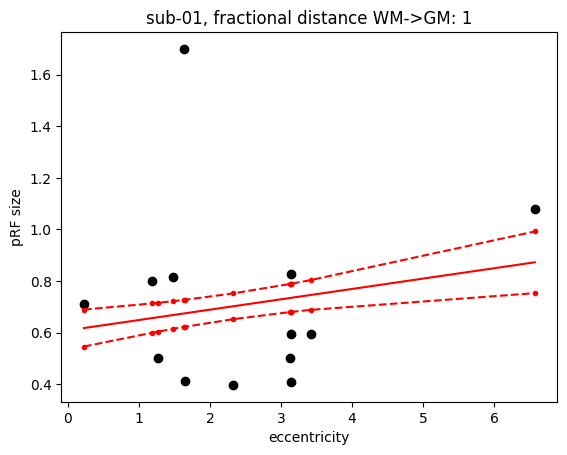

Intercept: 0.6087047543891739
t = 15.73, p = 0.00000
Slope: 0.04014910880088493
t = 3.12, p = 0.00180
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


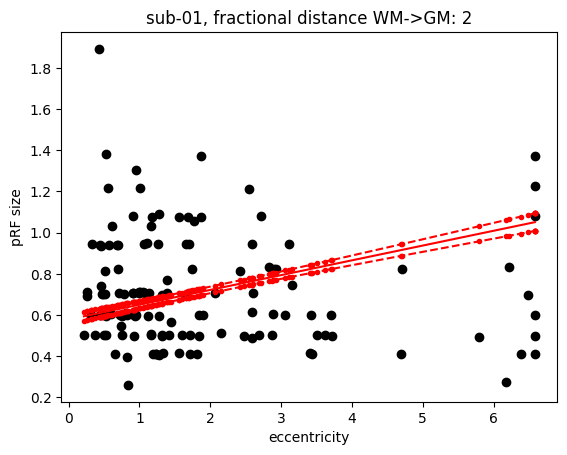

Intercept: 0.5787966120461747
t = 47.78, p = 0.00000
Slope: 0.07175153467957467
t = 16.09, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


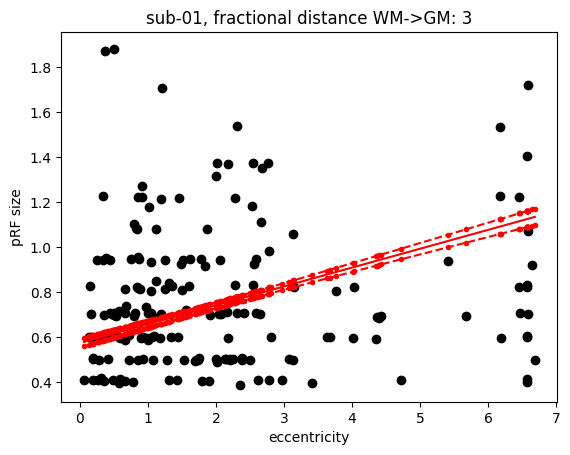

Intercept: 0.5747317521200981
t = 57.48, p = 0.00000
Slope: 0.08366869653226408
t = 22.43, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


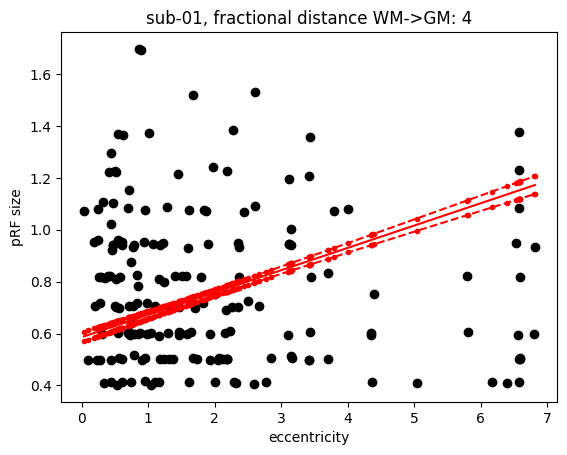

Intercept: 0.5860875284650575
t = 61.84, p = 0.00000
Slope: 0.08606787114421816
t = 24.91, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


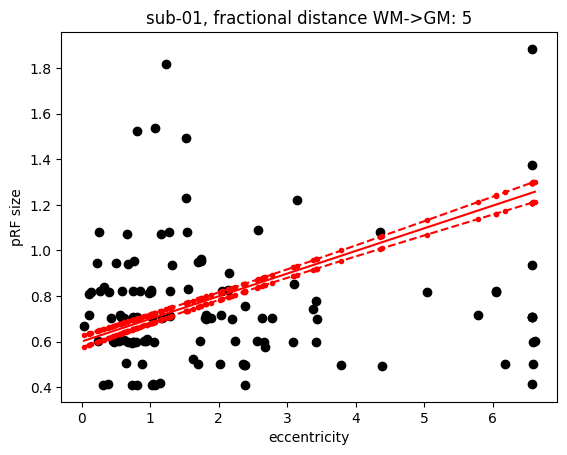

Intercept: 0.5998368684981559
t = 45.95, p = 0.00000
Slope: 0.09937659268163844
t = 21.37, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


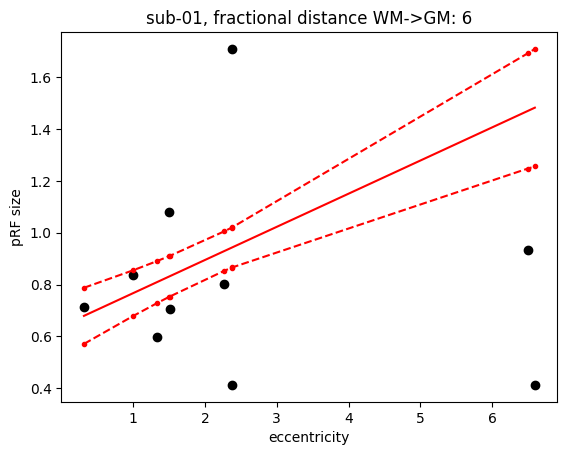

Intercept: 0.6390097841496777
t = 10.51, p = 0.00000
Slope: 0.1278687909680924
t = 5.39, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


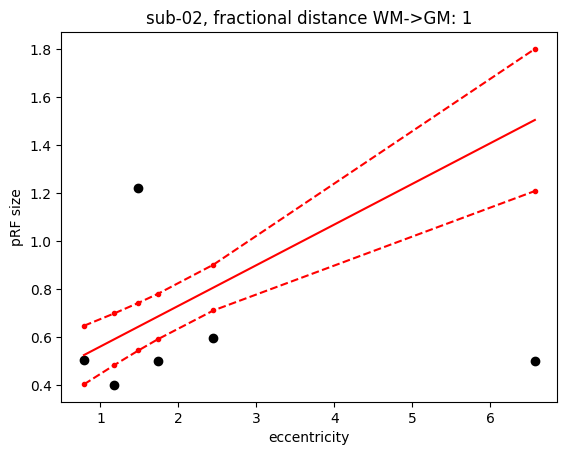

Intercept: 0.3908901239279216
t = 4.83, p = 0.00000
Slope: 0.1693439371305724
t = 5.32, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


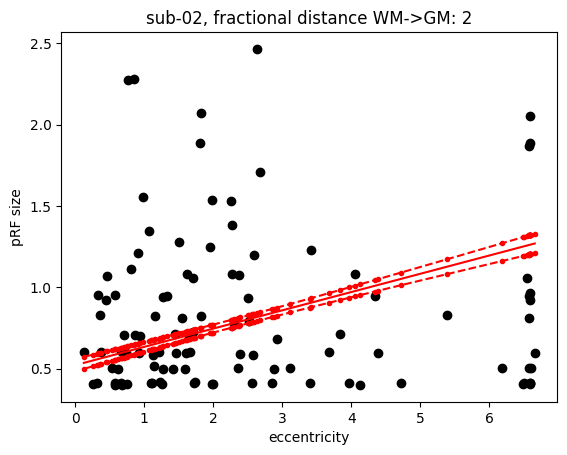

Intercept: 0.5213351597531244
t = 26.81, p = 0.00000
Slope: 0.11240043884399699
t = 17.40, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


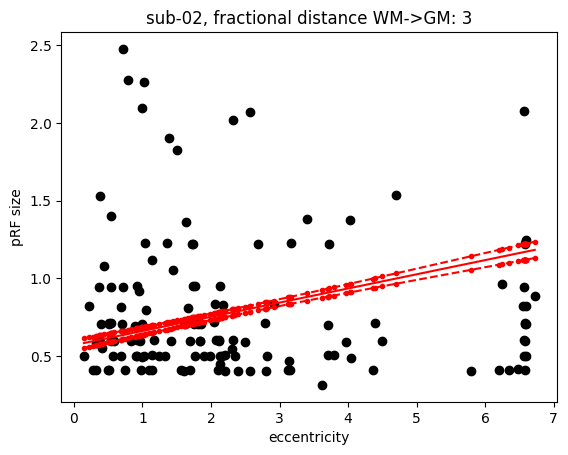

Intercept: 0.570409336896819
t = 34.48, p = 0.00000
Slope: 0.09113449084674835
t = 16.34, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


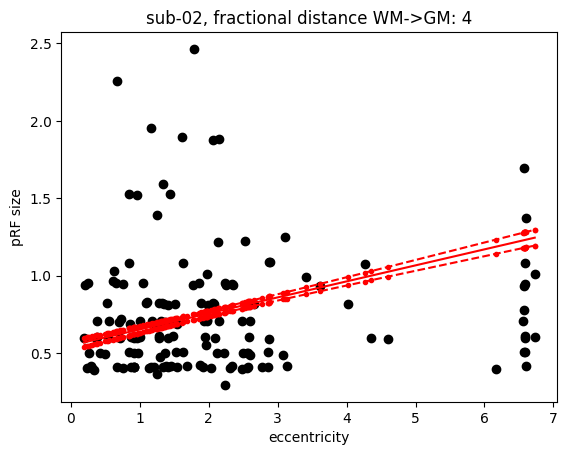

Intercept: 0.5490913276517337
t = 36.91, p = 0.00000
Slope: 0.10345723738222978
t = 19.43, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


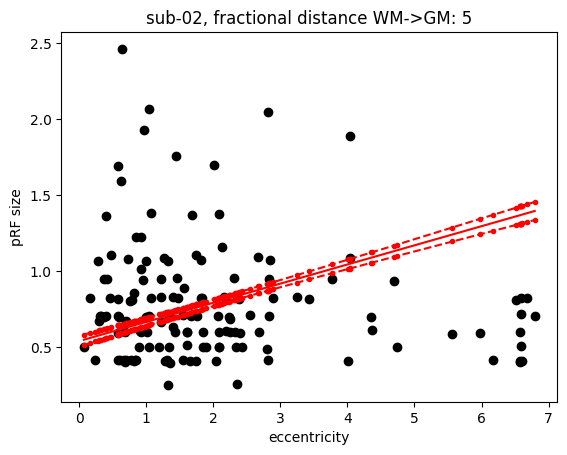

Intercept: 0.5396913734991805
t = 30.53, p = 0.00000
Slope: 0.1260627723478276
t = 20.31, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


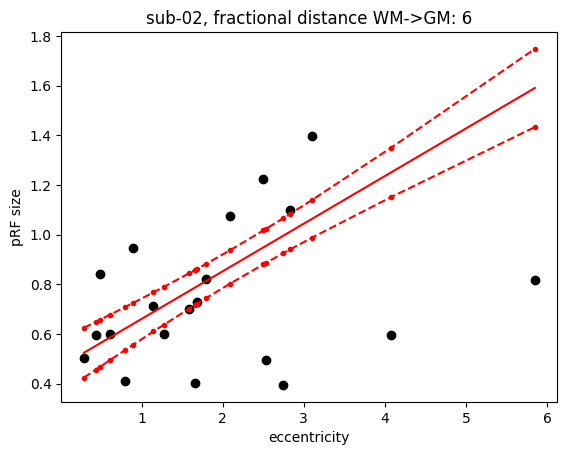

Intercept: 0.46886765279665954
t = 8.43, p = 0.00000
Slope: 0.19179677581063187
t = 9.63, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


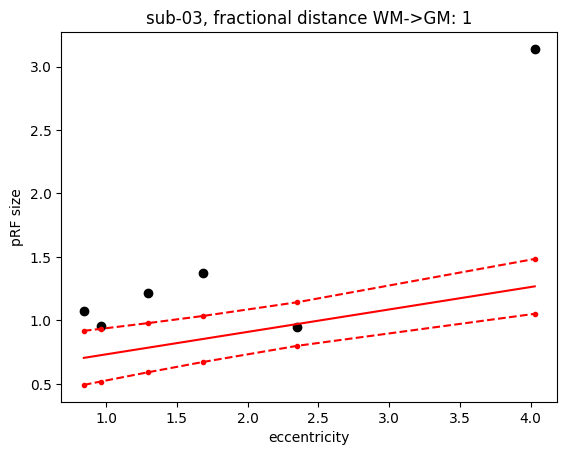

Intercept: 0.5552904490411741
t = 4.20, p = 0.00003
Slope: 0.176802849297665
t = 4.29, p = 0.00002
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


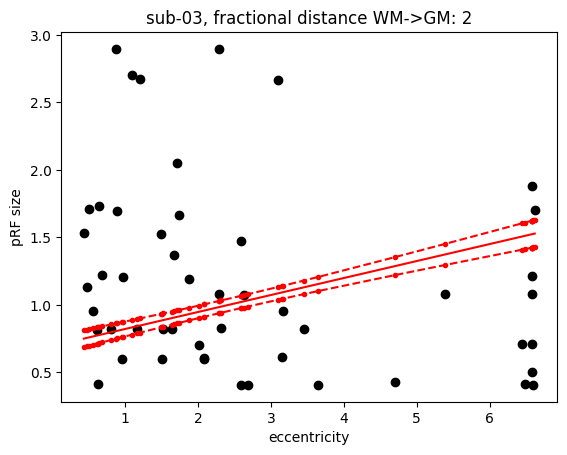

Intercept: 0.6949532325454849
t = 19.52, p = 0.00000
Slope: 0.12593738575063906
t = 11.40, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


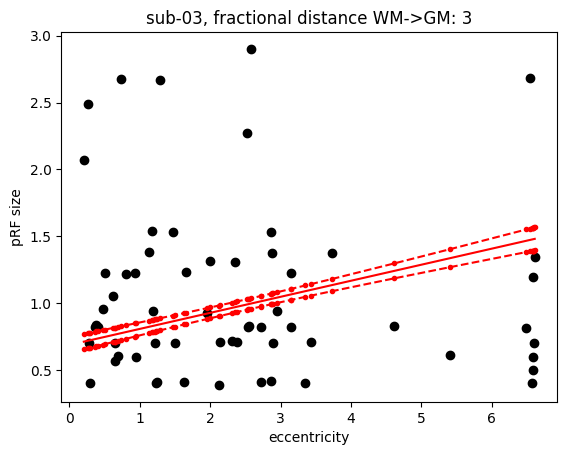

Intercept: 0.6884319190719717
t = 22.11, p = 0.00000
Slope: 0.11996051918447961
t = 12.56, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


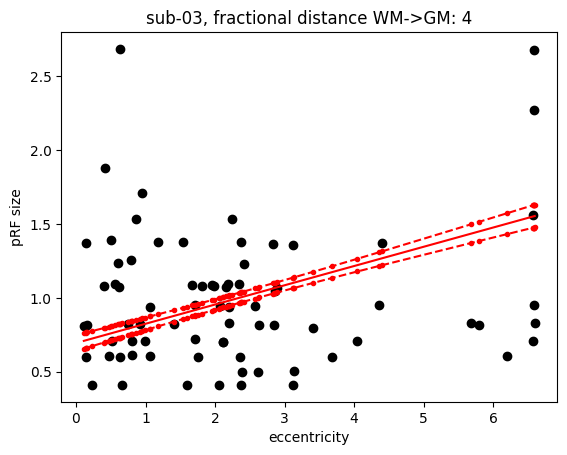

Intercept: 0.6942059063989892
t = 25.26, p = 0.00000
Slope: 0.13025702661965538
t = 15.34, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


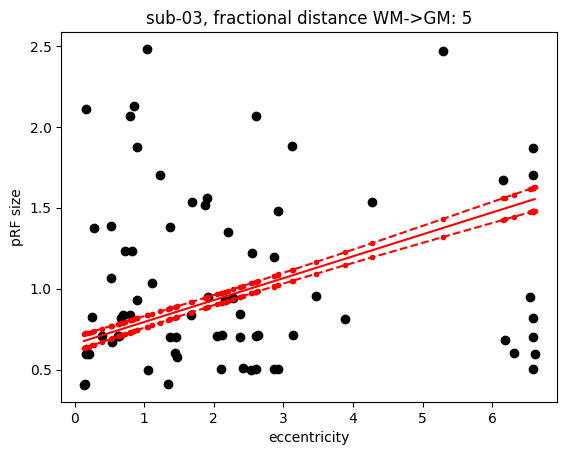

Intercept: 0.6580718299528081
t = 28.38, p = 0.00000
Slope: 0.13546487199936413
t = 17.60, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


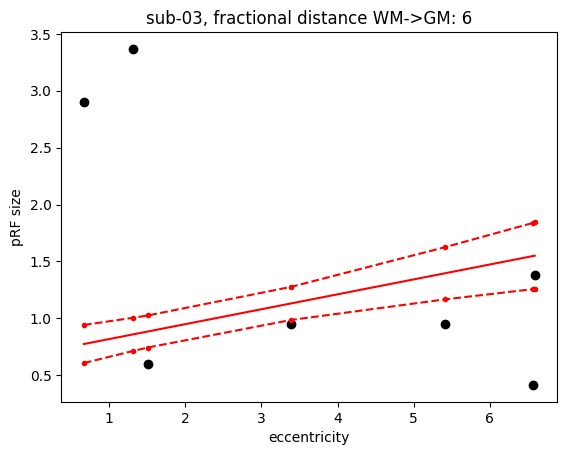

Intercept: 0.6864445439008657
t = 6.87, p = 0.00000
Slope: 0.13111008860503265
t = 4.16, p = 0.00003
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


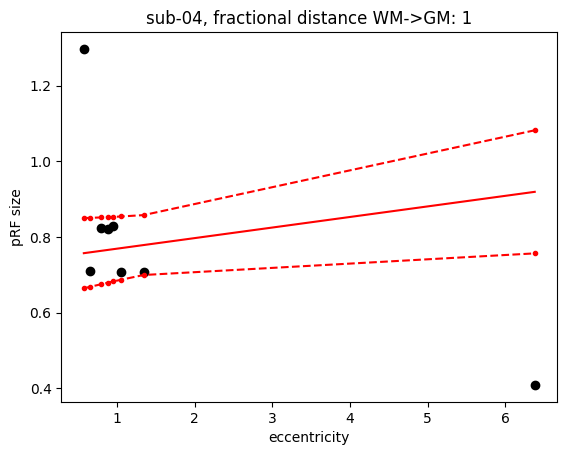

Intercept: 0.7413147075585735
t = 13.69, p = 0.00000
Slope: 0.027886158214820992
t = 1.57, p = 0.11648
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


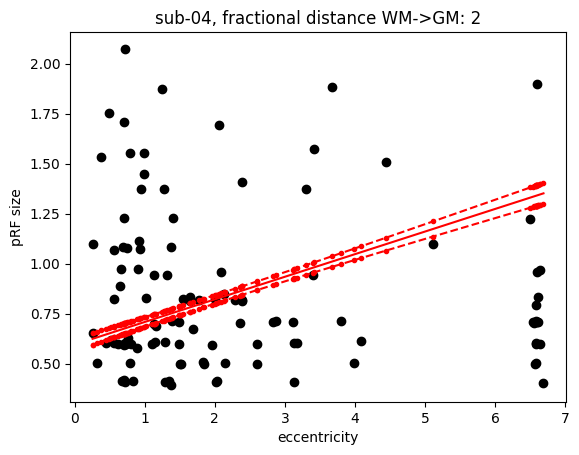

Intercept: 0.595384227582278
t = 37.67, p = 0.00000
Slope: 0.1129871919514733
t = 21.01, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


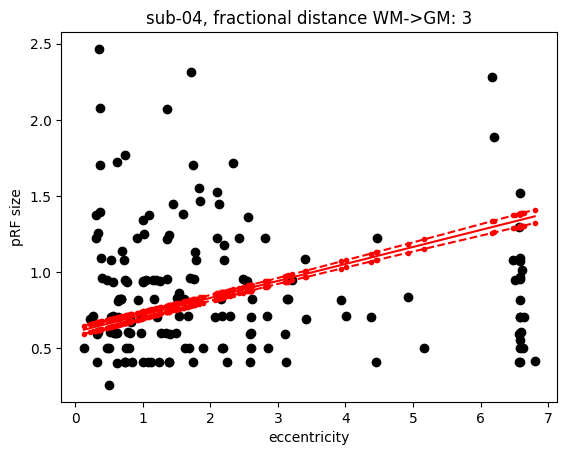

Intercept: 0.6078610910513157
t = 42.08, p = 0.00000
Slope: 0.11148350058442841
t = 24.36, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


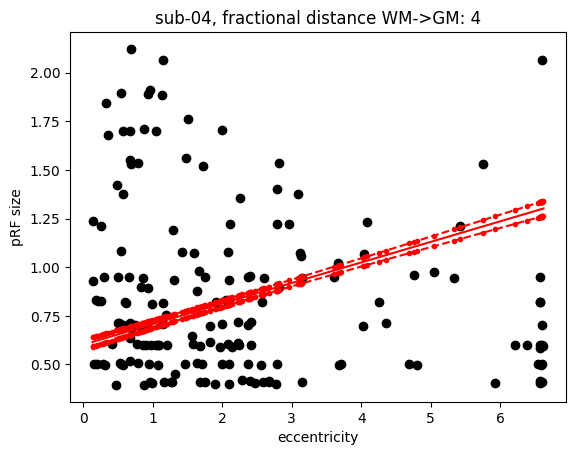

Intercept: 0.6020532515838732
t = 46.37, p = 0.00000
Slope: 0.10563974347717367
t = 25.26, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


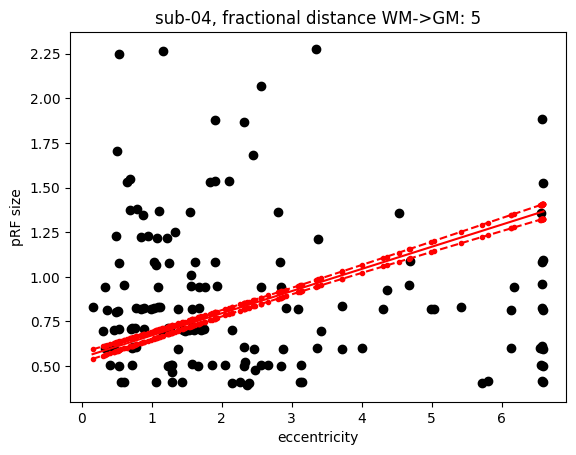

Intercept: 0.5472431065946709
t = 38.65, p = 0.00000
Slope: 0.12416702904379116
t = 27.14, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


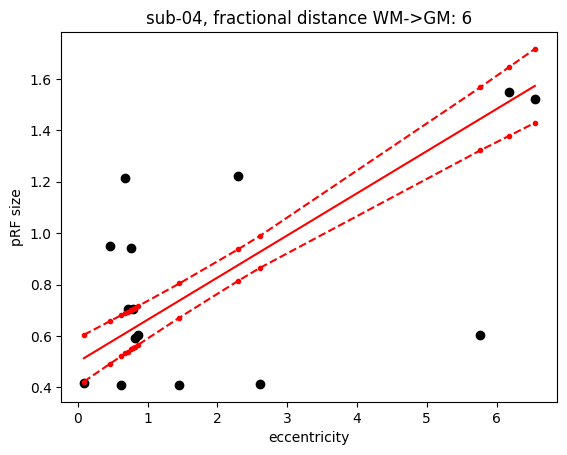

Intercept: 0.49943366541898093
t = 10.53, p = 0.00000
Slope: 0.16394140328997275
t = 10.53, p = 0.00000


In [16]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equidist_per_depth.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth['roi'] == 'V1') & 
                                    (df_equidist_per_depth['hem'] == 'lh') & 
                                    (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equidist_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equidist_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equidist_per_depth.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth['roi'] == 'V1') & 
                                    (df_equidist_per_depth['hem'] == 'rh') & 
                                    (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equidist_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equidist_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
#         # bin eccentricity data
#         bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
#         x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_equidist.loc[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equidist.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
            continue


        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(x_ecc, y_sigma, test_size=0.1)

        # Fit the model to the training set
        X_train = sm.add_constant(X_train)
        #model = sm.OLS(y_train, X_train).fit()
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

        # Make predictions on the test set
        X_test = sm.add_constant(X_test)
        y_pred = model.predict(X_test)

        # extract the prediction
        pred = model.get_prediction(X_test)

        # extract the intercept and slope
        intercept = model.params[0]
        slope = model.params[1]

        # extract the bootstrapped 95% quantiles and median of the fit
        quantiles = pred.summary_frame(alpha=0.05)
        median = pred.summary_frame(alpha=0.5)

        # plot the model
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_test), 'ko')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_pred), 'r-')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_lower'].values), 'r--.')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_upper'].values), 'r--.')
        plt.xlabel('eccentricity')
        plt.ylabel('pRF size')
        plt.title(subject_list[sub_id]+", fractional distance WM->GM: "+"{0:.2g}".format(depth_idx))
                  #str(depth_idx/10))
        plt.show()

        # print stats
        print(f"Intercept: {intercept}")
        intercept_txt = "t = "+"{:.2f}".format(model.tvalues[0])+", p = "+"{:.5f}".format(model.pvalues[0])
        print(intercept_txt)

        print(f"Slope: {slope}")
        slope_txt = "t = "+"{:.2f}".format(model.tvalues[1])+", p = "+"{:.5f}".format(model.pvalues[1])
        print(slope_txt)

        # get pRF estimate at 2deg
        pRF_est = intercept + target_ecc*slope

    #     # print the quantiles
    #     print("95% quantiles:")
    #     print(quantiles.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

    #     # print the median
    #     print("Median:")
    #     print(median.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

        # save stats to df
        idx=df_pRFxecc_stats_equidist.loc[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist['depth'] == depth_idx)].index.tolist()
        df_pRFxecc_stats_equidist.loc[idx, 'intercept-stats'] = pd.Series([intercept_txt]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
        df_pRFxecc_stats_equidist.loc[idx, 'slope-stats'] = pd.Series([slope_txt]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])

        df_pRFxecc_stats_equidist.loc[idx, 'intercept'] = pd.Series([intercept]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
        df_pRFxecc_stats_equidist.loc[idx, 'slope'] = pd.Series([slope]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])

        df_pRFxecc_stats_equidist.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
        
    

TODO: eccentricity bins and take avg pRF size in each bin, compute linear regression to these points, bootstrapping

In [17]:
df_pRFxecc_stats_equidist


sub id  depth  intercept     slope         intercept-stats  \
0   sub-01    1.0   0.608705  0.040149  t = 15.73, p = 0.00000   
1   sub-01    2.0   0.578797  0.071752  t = 47.78, p = 0.00000   
2   sub-01    3.0   0.574732  0.083669  t = 57.48, p = 0.00000   
3   sub-01    4.0   0.586088  0.086068  t = 61.84, p = 0.00000   
4   sub-01    5.0   0.599837  0.099377  t = 45.95, p = 0.00000   
5   sub-01    6.0   0.639010  0.127869  t = 10.51, p = 0.00000   
6   sub-02    1.0   0.390890  0.169344   t = 4.83, p = 0.00000   
7   sub-02    2.0   0.521335  0.112400  t = 26.81, p = 0.00000   
8   sub-02    3.0   0.570409  0.091134  t = 34.48, p = 0.00000   
9   sub-02    4.0   0.549091  0.103457  t = 36.91, p = 0.00000   
10  sub-02    5.0   0.539691  0.126063  t = 30.53, p = 0.00000   
11  sub-02    6.0   0.468868  0.191797   t = 8.43, p = 0.00000   
12  sub-03    1.0   0.555290  0.176803   t = 4.20, p = 0.00003   
13  sub-03    2.0   0.694953  0.125937  t = 19.52, p = 0.00000   
14  sub-03    3.0   0.688432  0.119961  t = 22.11, p = 0.00000   
15  sub-03    4.0   0.694206  0.130257  t = 25.26, p = 0.00000   
16  sub-03    5.0   0.658072  0.135465  t = 28.38, p = 0.00000   
17  sub-03    6.0   0.686445  0.131110   t = 6.87, p = 0.00000   
18  sub-04    1.0   0.741315  0.027886  t = 13.69, p = 0.00000   
19  sub-04    2.0   0.595384  0.112987  t = 37.67, p = 0.00000   
20  sub-04    3.0   0.607861  0.111484  t = 42.08, p = 0.00000   
21  sub-04    4.0   0.602053  0.105640  t = 46.37, p = 0.00000   
22  sub-04    5.0   0.547243  0.124167  t = 38.65, p = 0.00000   
23  sub-04    6.0   0.499434  0.163941  t = 10.53, p = 0.00000   

               slope-stats  pRF@2deg  
0    t = 3.12, p = 0.00180  0.689003  
1   t = 16.09, p = 0.00000  0.722300  
2   t = 22.43, p = 0.00000  0.742069  
3   t = 24.91, p = 0.00000  0.758223  
4   t = 21.37, p = 0.00000  0.798590  
5    t = 5.39, p = 0.00000  0.894747  
6    t = 5.32, p = 0.00000  0.729578  
7   t = 17.40, p = 0.00000  0.746136  
8   t = 16.34, p = 0.00000  0.752678  
9   t = 19.43, p = 0.00000  0.756006  
10  t = 20.31, p = 0.00000  0.791817  
11   t = 9.63, p = 0.00000  0.852461  
12   t = 4.29, p = 0.00002  0.908896  
13  t = 11.40, p = 0.00000  0.946828  
14  t = 12.56, p = 0.00000  0.928353  
15  t = 15.34, p = 0.00000  0.954720  
16  t = 17.60, p = 0.00000  0.929002  
17   t = 4.16, p = 0.00003  0.948665  
18   t = 1.57, p = 0.11648  0.797087  
19  t = 21.01, p = 0.00000  0.821359  
20  t = 24.36, p = 0.00000  0.830828  
21  t = 25.26, p = 0.00000  0.813333  
22  t = 27.14, p = 0.00000  0.795577  
23  t = 10.53, p = 0.00000  0.827316

#### Plot estimated pRF size at target eccentricity

[ 0.00708379 -0.01319376  0.70622941]
R2 quadratic: 0.9599506953356557
R2 linear: 0.888162625534251
[ 0.0060269  -0.020623    0.75221853]
R2 quadratic: 0.9530337502491205
R2 linear: 0.8169165341416983
[-0.00214852  0.0199462   0.89885135]
R2 quadratic: 0.403805420962151
R2 linear: 0.286579837656061
[-0.00127789  0.01055399  0.79669233]
R2 quadratic: 0.09319431527883615
R2 linear: 0.03972472945128025


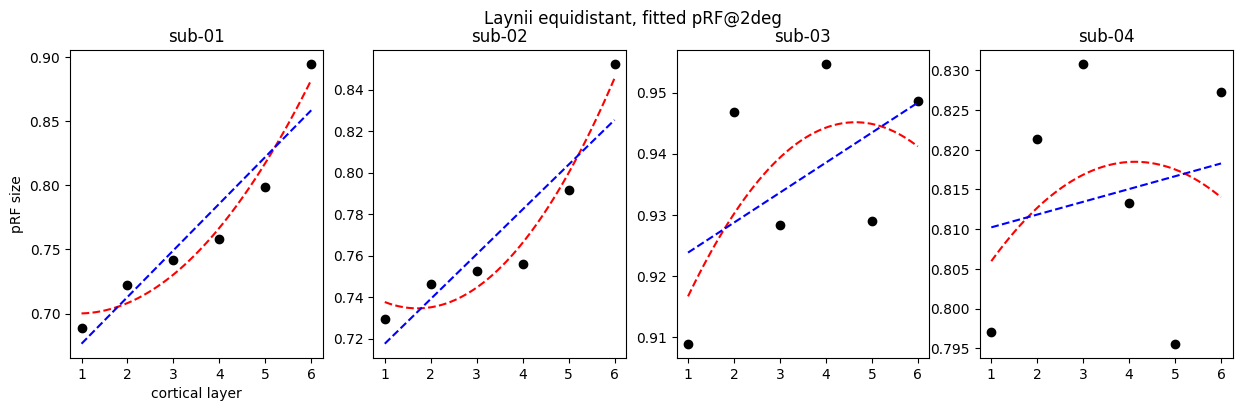

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equidist.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equidist.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.65, 1.05])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.05,5)) 
#     axs[sub_id].set_ylim([0.65, 0.95])
#     axs[sub_id].set_yticks(np.linspace(0.65,0.95,4)) 
    
plt.suptitle('Laynii equidistant, fitted pRF@2deg')
plt.show()
    
#     axs[sub_id].set_ylim([0.7, 1.1]4
#     axs[sub_id].set_yticks(np.linspace(0.7,1.1,5))    
    
#     df_pRFxecc_stats_equidist.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

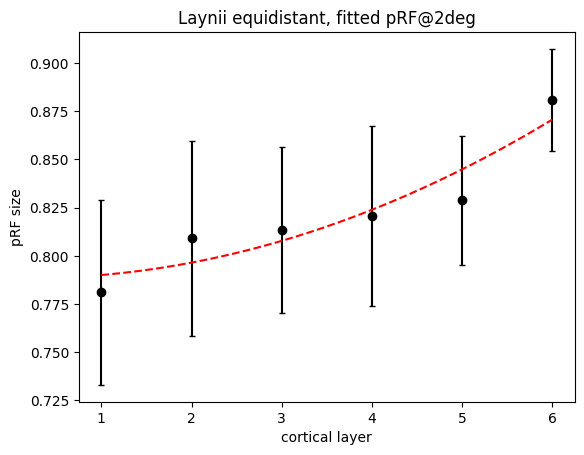

In [19]:
idx      = df_pRFxecc_stats_equidist[(df_pRFxecc_stats_equidist['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equidist.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equidist['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equidist.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_equidist.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equidist.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
# plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.title('Laynii equidistant, fitted pRF@2deg')
plt.show()


### Equivolumetric layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Extract lh and rh sigma and ecc values at chosen rsq threshold

In [20]:
target_ecc = 2
pRF_thresh = max_ecc_deg

Create a dataframe to save intercept and slope stats

In [21]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

intercept = np.empty((1,len(subs),)).tolist()
intercept = list(itertools.chain(*intercept))

slope = np.empty((1,len(subs),)).tolist()
slope = list(itertools.chain(*slope))

intercept_stats = np.empty((1,len(subs),)).tolist()
intercept_stats = list(itertools.chain(*intercept_stats))

slope_stats = np.empty((1,len(subs),)).tolist()
slope_stats = list(itertools.chain(*slope_stats))

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'intercept': intercept,
    'slope': slope,
    'intercept-stats' : intercept_stats,
    'slope-stats' : slope_stats,
    'pRF@2deg': pRF_2deg
})

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


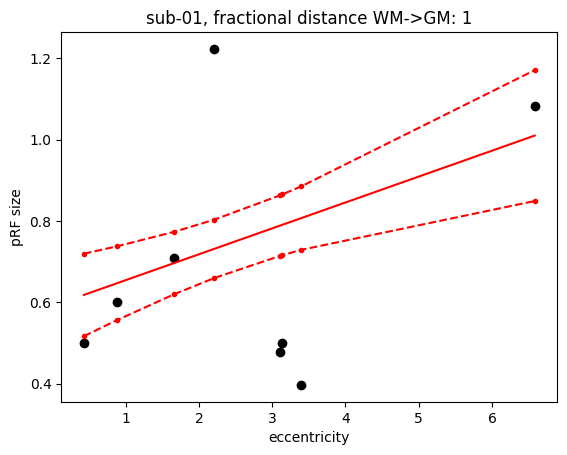

Intercept: 0.5909072324007552
t = 10.28, p = 0.00000
Slope: 0.06367647066360207
t = 3.54, p = 0.00039
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


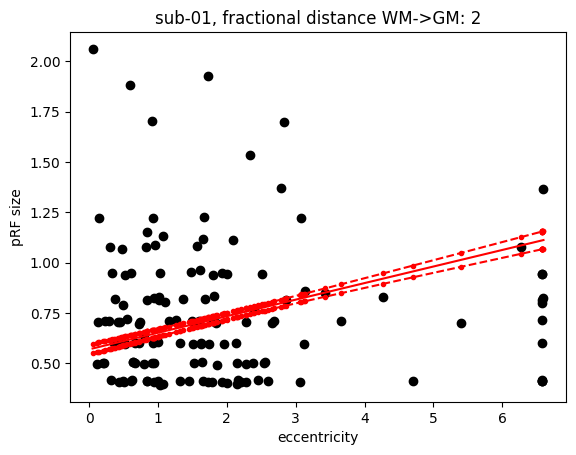

Intercept: 0.5694934208362186
t = 45.12, p = 0.00000
Slope: 0.08227129290527072
t = 17.90, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


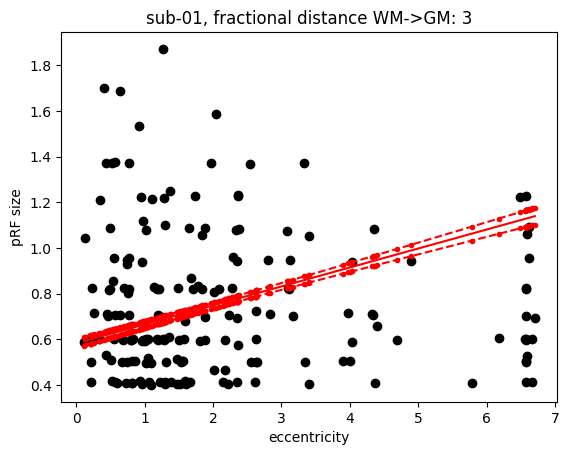

Intercept: 0.5818313627945981
t = 57.83, p = 0.00000
Slope: 0.08317427819301859
t = 22.11, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


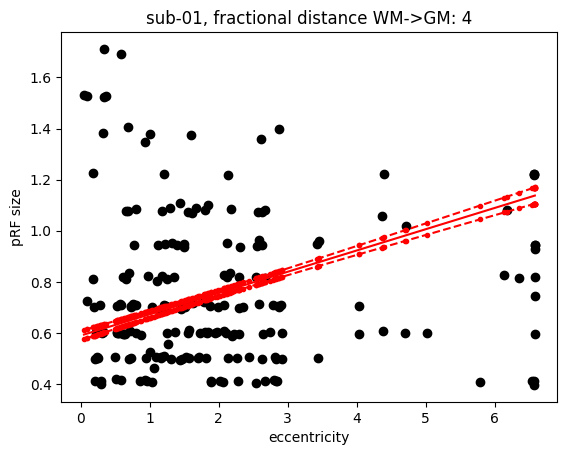

Intercept: 0.5893891966773399
t = 64.70, p = 0.00000
Slope: 0.08324856118506896
t = 24.97, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


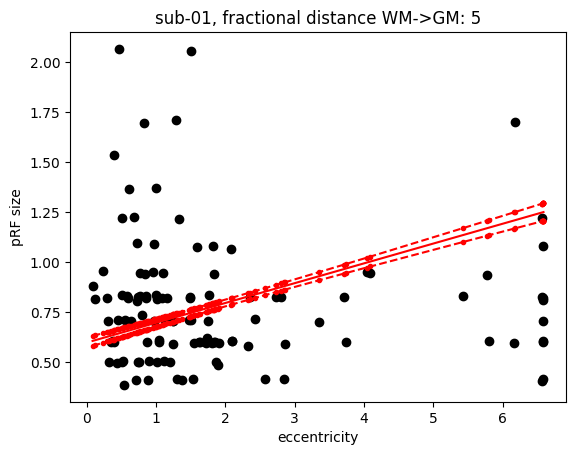

Intercept: 0.5973756719973791
t = 45.96, p = 0.00000
Slope: 0.09901402940372565
t = 21.34, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


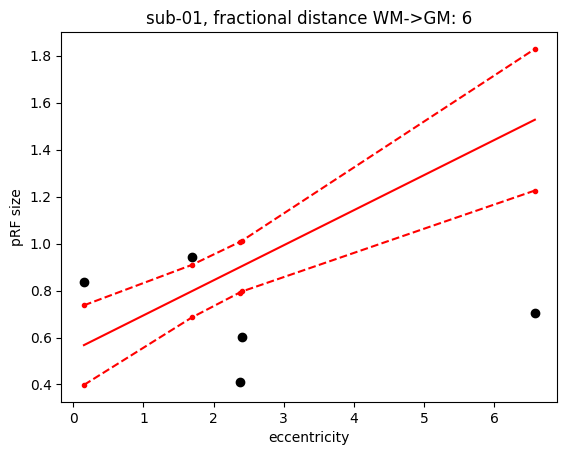

Intercept: 0.5448981829337217
t = 6.03, p = 0.00000
Slope: 0.14925597103520793
t = 4.55, p = 0.00001
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


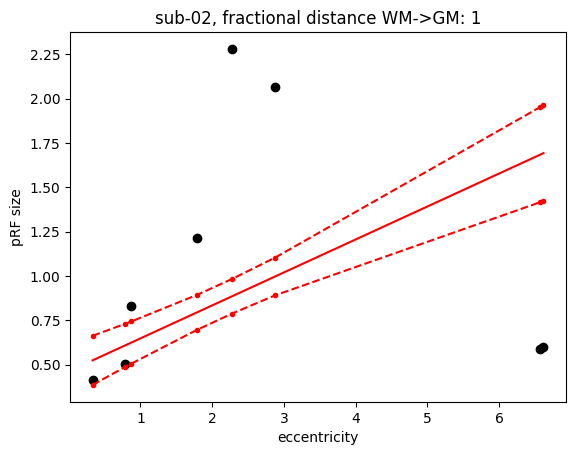

Intercept: 0.4617940877802226
t = 5.94, p = 0.00000
Slope: 0.1859975185420279
t = 6.52, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


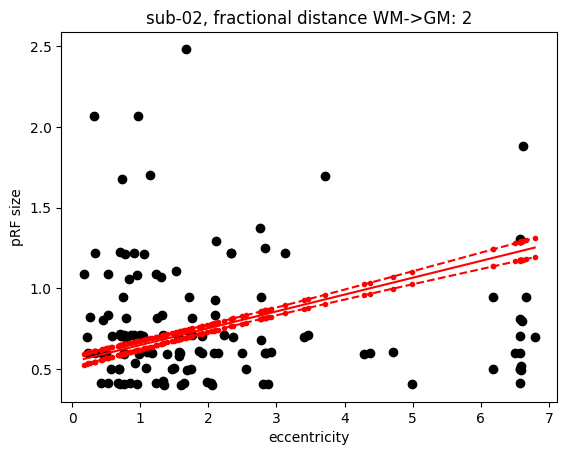

Intercept: 0.544456746070392
t = 29.91, p = 0.00000
Slope: 0.10435879388065203
t = 16.80, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


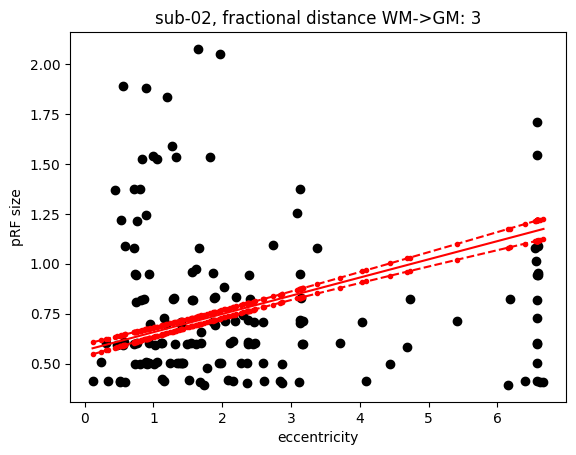

Intercept: 0.5658353346732503
t = 35.81, p = 0.00000
Slope: 0.09124361812765108
t = 16.60, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


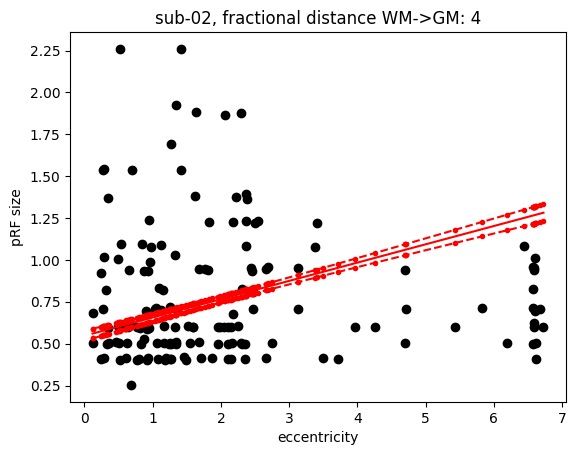

Intercept: 0.5468791974304397
t = 35.96, p = 0.00000
Slope: 0.10925788831033742
t = 20.16, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


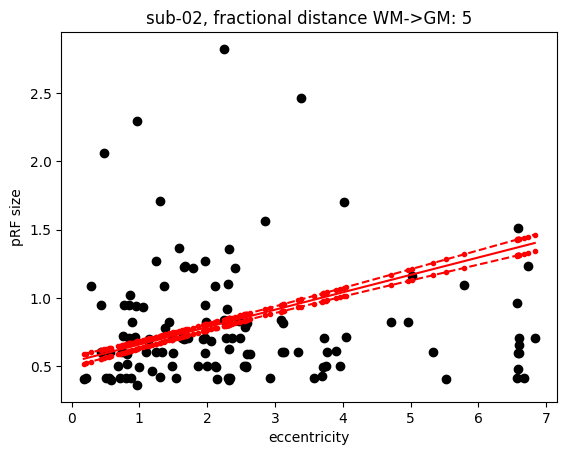

Intercept: 0.5303477730447472
t = 28.27, p = 0.00000
Slope: 0.12753626910748345
t = 19.80, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


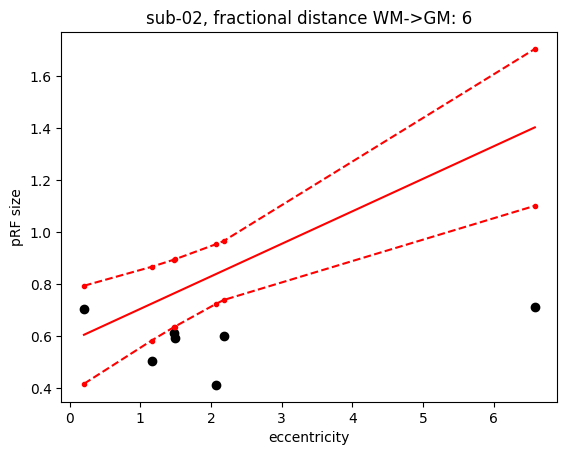

Intercept: 0.5788184131874202
t = 5.67, p = 0.00000
Slope: 0.12515366275800816
t = 3.62, p = 0.00029
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


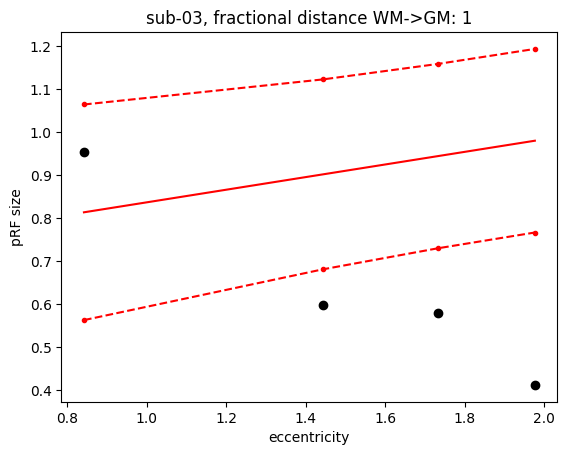

Intercept: 0.6899063157589862
t = 4.25, p = 0.00002
Slope: 0.14662498360065218
t = 2.32, p = 0.02041
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


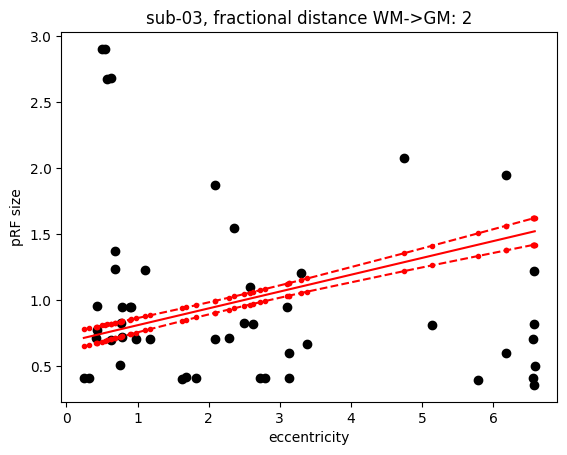

Intercept: 0.6800506805332981
t = 19.41, p = 0.00000
Slope: 0.1274404747806064
t = 11.55, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


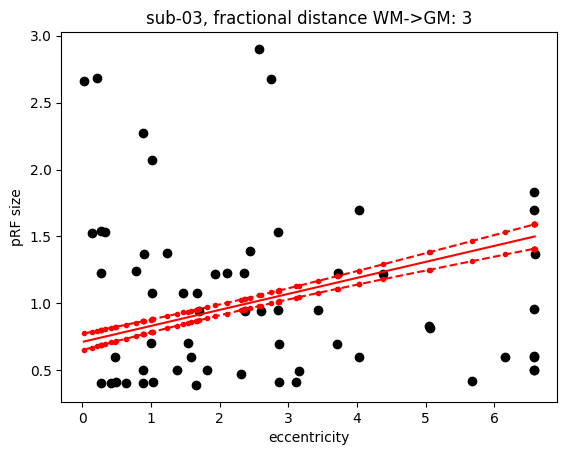

Intercept: 0.7135363884239063
t = 23.01, p = 0.00000
Slope: 0.11940971013980885
t = 12.09, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


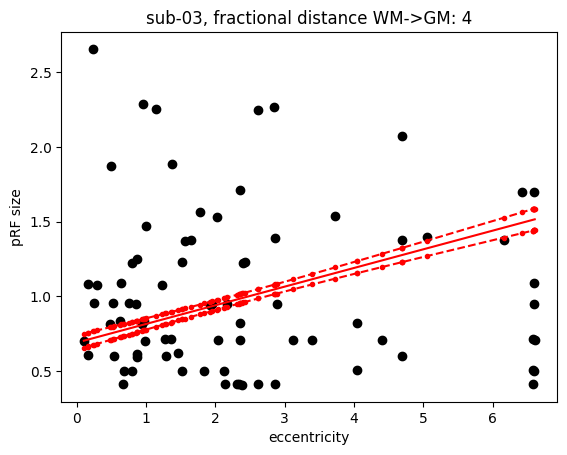

Intercept: 0.6898532106607003
t = 28.04, p = 0.00000
Slope: 0.12484473543069102
t = 15.83, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


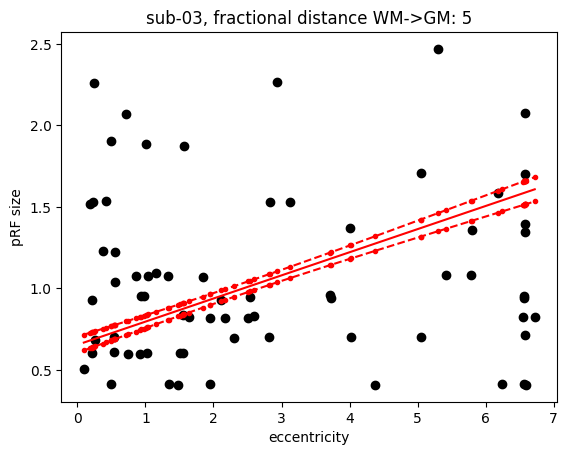

Intercept: 0.6544700873304323
t = 25.92, p = 0.00000
Slope: 0.14186811316086753
t = 17.92, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


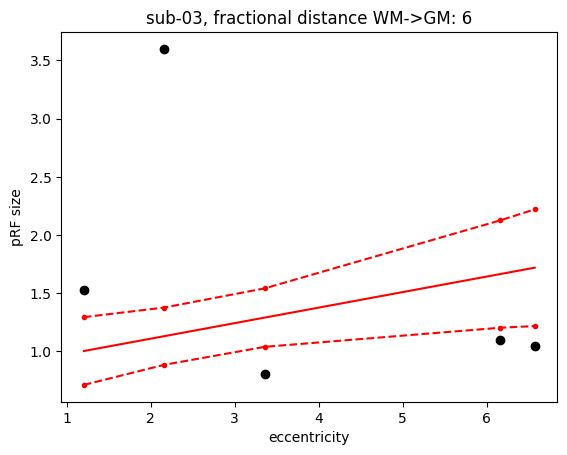

Intercept: 0.8428018115029927
t = 4.29, p = 0.00002
Slope: 0.13333071317047457
t = 2.31, p = 0.02073
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


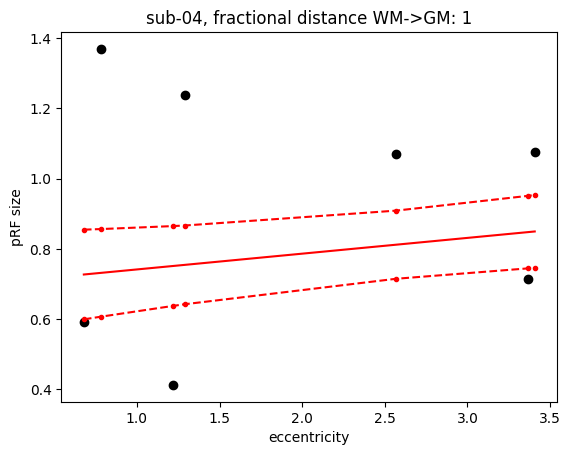

Intercept: 0.6966427832977442
t = 9.18, p = 0.00000
Slope: 0.04489925496551021
t = 2.00, p = 0.04549
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


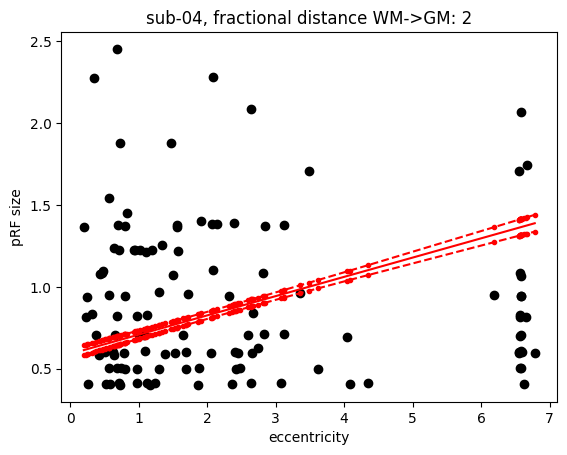

Intercept: 0.5903960356601134
t = 36.14, p = 0.00000
Slope: 0.11764075792155729
t = 22.16, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


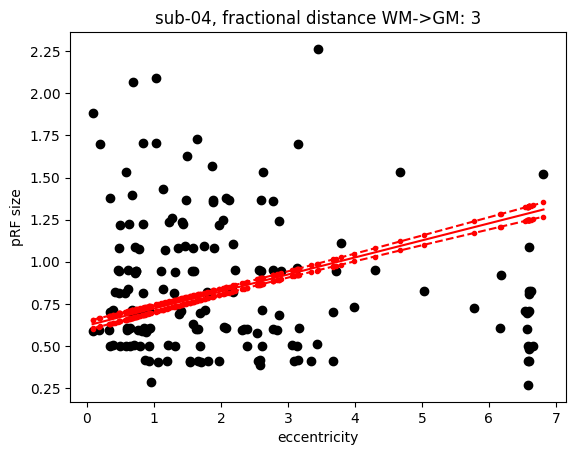

Intercept: 0.6208205190979772
t = 45.82, p = 0.00000
Slope: 0.10113430916371725
t = 23.13, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


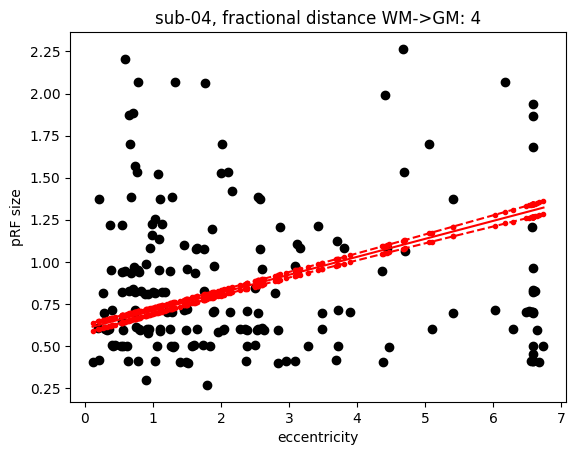

Intercept: 0.6022021854308305
t = 48.19, p = 0.00000
Slope: 0.10688276175486391
t = 26.24, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


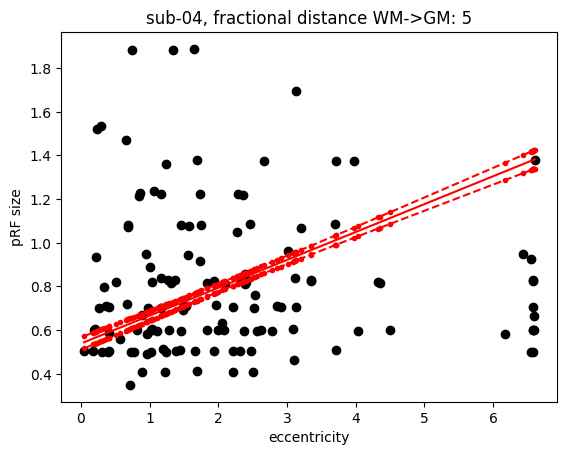

Intercept: 0.5385358143256298
t = 37.16, p = 0.00000
Slope: 0.12766768599579803
t = 27.20, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


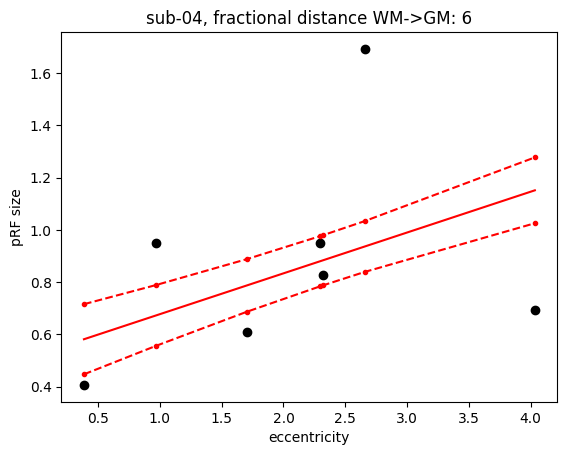

Intercept: 0.5212368105454837
t = 6.91, p = 0.00000
Slope: 0.15631533248697993
t = 6.37, p = 0.00000


In [22]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'lh') & 
                                     (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'rh') & 
                                            (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
#         # bin eccentricity data
#         bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
#         x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 20:
            idx=df_pRFxecc_stats_equivol.loc[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equivol.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
            continue


        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(x_ecc, y_sigma, test_size=0.1)

        # Fit the model to the training set
        X_train = sm.add_constant(X_train)
        #model = sm.OLS(y_train, X_train).fit()
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

        # Make predictions on the test set
        X_test = sm.add_constant(X_test)
        y_pred = model.predict(X_test)

        # extract the prediction
        pred = model.get_prediction(X_test)

        # extract the intercept and slope
        intercept = model.params[0]
        slope = model.params[1]

        # extract the bootstrapped 95% quantiles and median of the fit
        quantiles = pred.summary_frame(alpha=0.05)
        median = pred.summary_frame(alpha=0.5)

        # plot the model
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_test), 'ko')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_pred), 'r-')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_lower'].values), 'r--.')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_upper'].values), 'r--.')
        plt.xlabel('eccentricity')
        plt.ylabel('pRF size')
        plt.title(subject_list[sub_id]+", fractional distance WM->GM: "+"{0:.2g}".format(depth_idx))
                  #str(depth_idx/10))
        plt.show()

        # print stats
        print(f"Intercept: {intercept}")
        intercept_txt = "t = "+"{:.2f}".format(model.tvalues[0])+", p = "+"{:.5f}".format(model.pvalues[0])
        print(intercept_txt)

        print(f"Slope: {slope}")
        slope_txt = "t = "+"{:.2f}".format(model.tvalues[1])+", p = "+"{:.5f}".format(model.pvalues[1])
        print(slope_txt)

        # get pRF estimate at 2deg
        pRF_est = intercept + target_ecc*slope

    #     # print the quantiles
    #     print("95% quantiles:")
    #     print(quantiles.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

    #     # print the median
    #     print("Median:")
    #     print(median.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

        # save stats to df
        idx=df_pRFxecc_stats_equivol.loc[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol['depth'] == depth_idx)].index.tolist()
        df_pRFxecc_stats_equivol.loc[idx, 'intercept-stats'] = pd.Series([intercept_txt]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        df_pRFxecc_stats_equivol.loc[idx, 'slope-stats'] = pd.Series([slope_txt]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])

        df_pRFxecc_stats_equivol.loc[idx, 'intercept'] = pd.Series([intercept]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        df_pRFxecc_stats_equivol.loc[idx, 'slope'] = pd.Series([slope]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])

        df_pRFxecc_stats_equivol.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        
    

In [23]:
df_pRFxecc_stats_equivol.head()


sub id  depth  intercept     slope         intercept-stats  \
0  sub-01    1.0   0.590907  0.063676  t = 10.28, p = 0.00000   
1  sub-01    2.0   0.569493  0.082271  t = 45.12, p = 0.00000   
2  sub-01    3.0   0.581831  0.083174  t = 57.83, p = 0.00000   
3  sub-01    4.0   0.589389  0.083249  t = 64.70, p = 0.00000   
4  sub-01    5.0   0.597376  0.099014  t = 45.96, p = 0.00000   

              slope-stats  pRF@2deg  
0   t = 3.54, p = 0.00039  0.718260  
1  t = 17.90, p = 0.00000  0.734036  
2  t = 22.11, p = 0.00000  0.748180  
3  t = 24.97, p = 0.00000  0.755886  
4  t = 21.34, p = 0.00000  0.795404

#### Plot estimated pRF size at target eccentricity

[ 0.00469012 -0.00947201  0.72788125]
R2 quadratic: 0.9803756331988915
R2 linear: 0.9027357164019539
[ 0.01287696 -0.08755316  0.89700675]
R2 quadratic: 0.8927051479695168
R2 linear: 0.016557320841976142
[ 0.01825653 -0.10983726  1.08381571]
R2 quadratic: 0.7909914497836743
R2 linear: 0.2468191501197503
[-0.00132558  0.01312447  0.78732131]
R2 quadratic: 0.1824504847002505
R2 linear: 0.14555295515314493


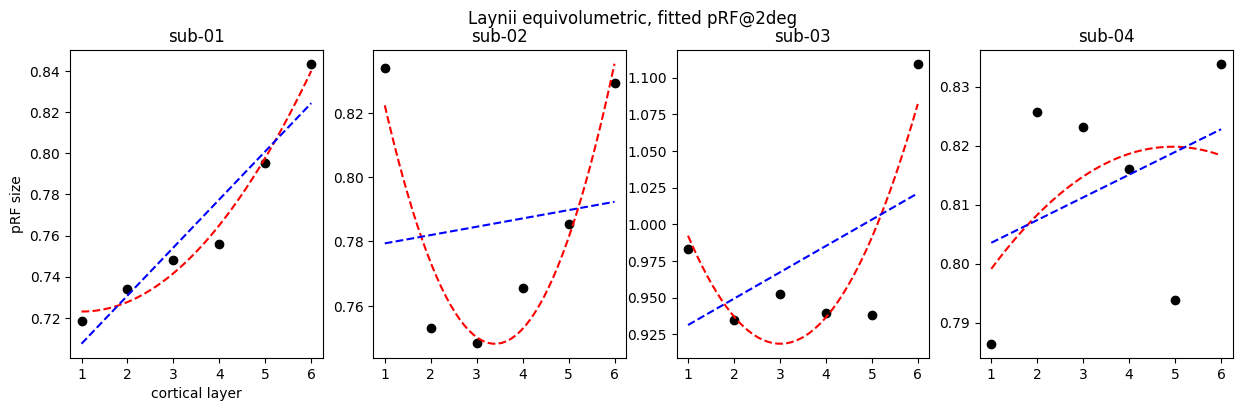

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))


for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equivol.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.6, 1.0])
#     axs[sub_id].set_yticks(np.linspace(0.6,1.0,5)) 
#     axs[sub_id].set_ylim([0.65, 0.9])
#     axs[sub_id].set_yticks(np.linspace(0.65,0.9,6))  
    
plt.suptitle('Laynii equivolumetric, fitted pRF@2deg')
plt.show()
    
#     df_pRFxecc_stats_equivol.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equivol_per_depth['hem'] == 'lh') & 
#                                 (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

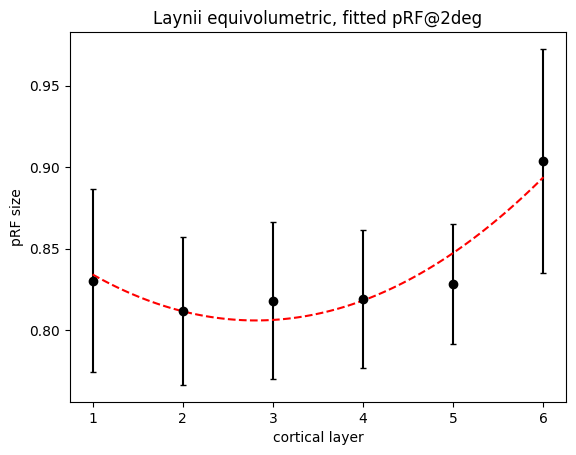

In [25]:
idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equivol.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equivol['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)

# data for plot
depth_plot    = df_pRFxecc_stats_equivol.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equivol.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
# plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.title('Laynii equivolumetric, fitted pRF@2deg')
plt.show()

## Laynii layers: pRF per cortical layer fitted at manually-defined iso-eccentricity band

### Equidistant layering

#### pRF size at 2deg eccentricity (separately for each cortical layer)

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Thresholds

In [26]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [27]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [28]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equidist_2ecc = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [29]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        # lh
        idx=df_equidist_per_depth_ecc2.loc[(df_equidist_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth_ecc2['hem'] == 'lh') & 
                                    (df_equidist_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equidist_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equidist_per_depth_ecc2.loc[(df_equidist_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth_ecc2['hem'] == 'rh') & 
                                    (df_equidist_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equidist_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
        # bin eccentricity data
        bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_equidist_2ecc.loc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist_2ecc['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equidist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equidist_2ecc.index[idx])
            continue


        # get pRF estimate at 2deg
        pRF_est = np.mean(y_sigma)


        # save stats to df
        idx=df_pRFxecc_stats_equidist_2ecc.loc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist_2ecc['depth'] == depth_idx)].index.tolist()

        df_pRFxecc_stats_equidist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equidist_2ecc.index[idx])
        
    

In [30]:
df_pRFxecc_stats_equidist_2ecc


sub id  depth  pRF@2deg
0   sub-01    1.0  0.650550
1   sub-01    2.0  0.718650
2   sub-01    3.0  0.748120
3   sub-01    4.0  0.744522
4   sub-01    5.0  0.781408
5   sub-01    6.0  0.904710
6   sub-02    1.0  0.671792
7   sub-02    2.0  0.757992
8   sub-02    3.0  0.734977
9   sub-02    4.0  0.721570
10  sub-02    5.0  0.739317
11  sub-02    6.0  0.826670
12  sub-03    1.0       NaN
13  sub-03    2.0  1.082284
14  sub-03    3.0  1.065147
15  sub-03    4.0  1.103888
16  sub-03    5.0  1.062247
17  sub-03    6.0       NaN
18  sub-04    1.0  0.768712
19  sub-04    2.0  0.853007
20  sub-04    3.0  0.898480
21  sub-04    4.0  0.871968
22  sub-04    5.0  0.871057
23  sub-04    6.0  0.891685

#### Plot estimated pRF size at target eccentricity

[0.00545844 0.00337587 0.66339154]
R2 quadratic: 0.8851853443924428
R2 linear: 0.853803306110198
[ 0.00301458 -0.00096039  0.69969307]
R2 quadratic: 0.5798966227849043
R2 linear: 0.553448270920222
[-0.00612594  0.04074467  1.01848529]
R2 quadratic: 0.15703961536311029
R2 linear: 0.02073322775966524
[-0.00899772  0.08134125  0.71092277]
R2 quadratic: 0.8015420893997789
R2 linear: 0.529938666117314


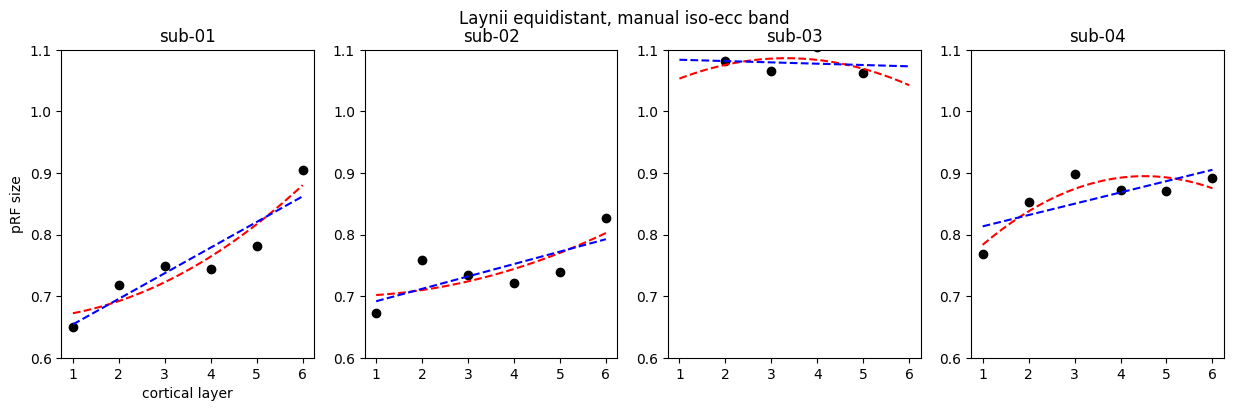

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equidist_2ecc.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equidist_2ecc.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.65, 1.15])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6)) 
    axs[sub_id].set_ylim([0.6, 1.1])
    axs[sub_id].set_yticks(np.linspace(0.6,1.1,6)) 
    

plt.suptitle('Laynii equidistant, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_equidist_2ecc.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

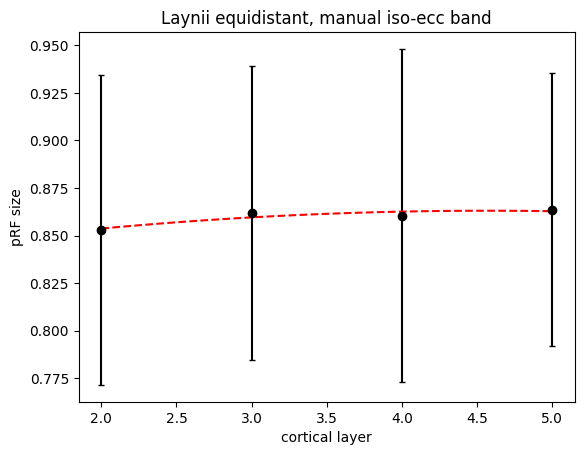

In [32]:
idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equidist_2ecc.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equidist_2ecc['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equidist_2ecc.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_equidist_2ecc.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equidist_2ecc.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
#plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')


plt.title('Laynii equidistant, manual iso-ecc band')
plt.show()


### Equivolumetric layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Extract lh and rh sigma and ecc values at chosen rsq threshold

In [33]:
target_ecc = 2
pRF_thresh = max_ecc_deg

Create a dataframe to save intercept and slope stats

In [34]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol_2ecc = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [35]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        # lh
        idx=df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                          (df_equivol_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equivol_per_depth_ecc2['hem'] == 'lh') & 
                                    (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                                 (df_equivol_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equivol_per_depth_ecc2['hem'] == 'rh') & 
                                    (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
        # bin eccentricity data
        bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol_2ecc['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])
            continue


        # get pRF estimate at 2deg
        pRF_est = np.mean(y_sigma)


        # save stats to df
        idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol_2ecc['depth'] == depth_idx)].index.tolist()

        df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])
        
    

In [36]:
df_pRFxecc_stats_equivol_2ecc.head()


sub id  depth  pRF@2deg
0  sub-01    1.0  0.669891
1  sub-01    2.0  0.717945
2  sub-01    3.0  0.734753
3  sub-01    4.0  0.745139
4  sub-01    5.0  0.789512

#### Plot estimated pRF size at target eccentricity

[-0.00098458  0.03255106  0.64462553]
R2 quadratic: 0.9431116400199474
R2 linear: 0.9413120286728965
[ 0.01424853 -0.08571659  0.84684532]
R2 quadratic: 0.8932023707021954
R2 linear: 0.278911284404308
[-0.00716969  0.06682274  0.93530783]
R2 quadratic: 0.3545159737712348
R2 linear: 0.30864765664221794
[ 0.00147679 -0.00666452  0.87687531]
R2 quadratic: 0.14312935905046265
R2 linear: 0.10642670068833937


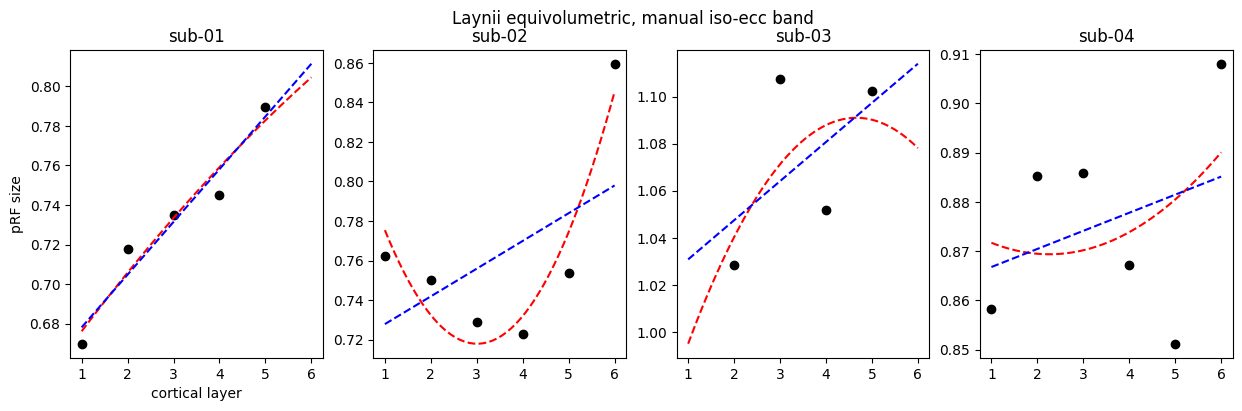

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))


for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.65, 1.15])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6))  
#     axs[sub_id].set_ylim([0.65, 1.05])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.05,5)) 
    
plt.suptitle('Laynii equivolumetric, manual iso-ecc band')
plt.show()
#     df_pRFxecc_stats_equivol_2ecc.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equivol_per_depth['hem'] == 'lh') & 
#                                 (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

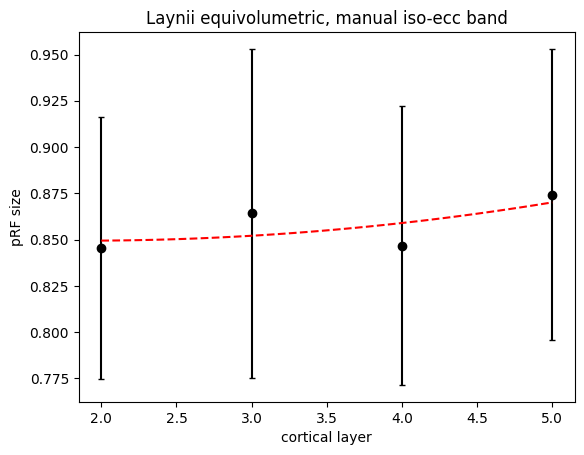

In [38]:
idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equivol_2ecc['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)

# ################################################
# # Fit the quadratic equation
# coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)

# # Fit the linear equation
# coefs_linear = np.polyfit(depth, pRF_2deg, 1)

# # # Create a polynomial function from the coefficients
# # f_quadratic = np.poly1d(coefs_quadratic)
# # f_linear = np.poly1d(coefs_linear)

# # # calculate the R-squared
# # r_squared = r2_score(pRF_2deg, f_quadratic(depth))
# # print(f"R2 quadratic: {r_squared}")
# # r_squared = r2_score(pRF_2deg, f_linear(depth))
# # print(f"R2 linear: {r_squared}")
# #################################################

# data for plot
depth_plot    = df_pRFxecc_stats_equivol_2ecc.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equivol_2ecc.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
#plt.plot(X_plot/n_layers,y_median,'b--')
# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')
plt.title('Laynii equivolumetric, manual iso-ecc band')
plt.show()


## #############################################################

## #############################################################

## Euclidean distances: pRF per cortical layer fitted at target eccentricity

### Equidistant layering

#### pRF size as a function of eccentricity (separately for each cortical layer)
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Thresholds

In [39]:
target_ecc = 2
pRF_thresh = max_ecc_deg

Cortical distance bins

In [40]:
cd_bins  = np.linspace(-2.5,2.5,n_layers)
cd_bins

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])

Create a dataframe to save intercept and slope stats

In [41]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = cd_bins.tolist()
depths = depth*n_sub

intercept = np.empty((1,len(subs),)).tolist()
intercept = list(itertools.chain(*intercept))

slope = np.empty((1,len(subs),)).tolist()
slope = list(itertools.chain(*slope))

intercept_stats = np.empty((1,len(subs),)).tolist()
intercept_stats = list(itertools.chain(*intercept_stats))

slope_stats = np.empty((1,len(subs),)).tolist()
slope_stats = list(itertools.chain(*slope_stats))

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_cortdist = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'intercept': intercept,
    'slope': slope,
    'intercept-stats' : intercept_stats,
    'slope-stats' : slope_stats,
    'pRF@2deg': pRF_2deg
})

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


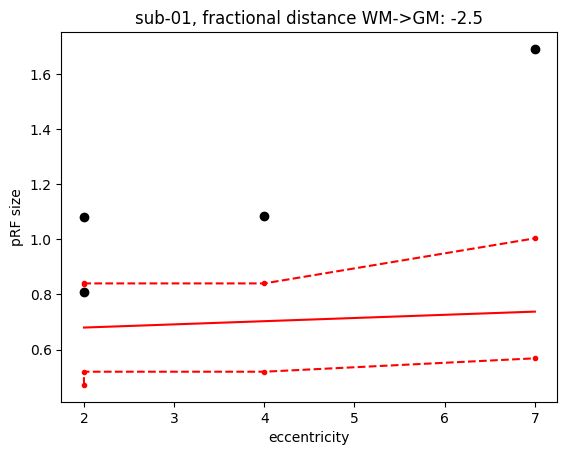

Intercept: 0.6568095224259255
t = 4.97, p = 0.00000
Slope: 0.011560350071491018
t = 0.35, p = 0.72828


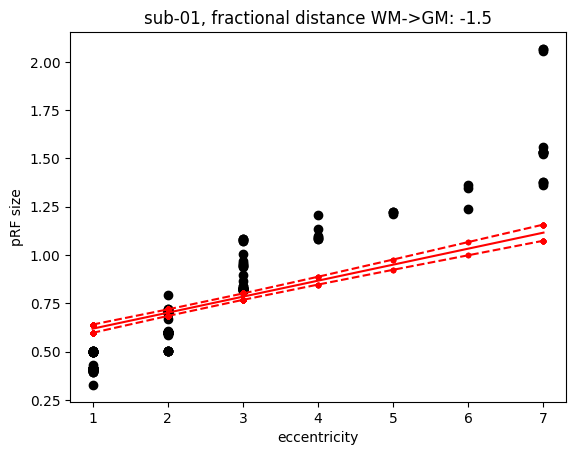

Intercept: 0.5355742649053725
t = 37.53, p = 0.00000
Slope: 0.0829007182384795
t = 18.50, p = 0.00000


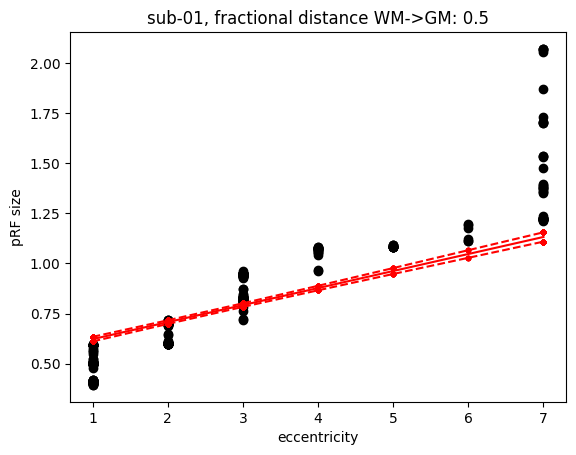

Intercept: 0.5374270791791116
t = 70.03, p = 0.00000
Slope: 0.08492682463704934
t = 34.46, p = 0.00000


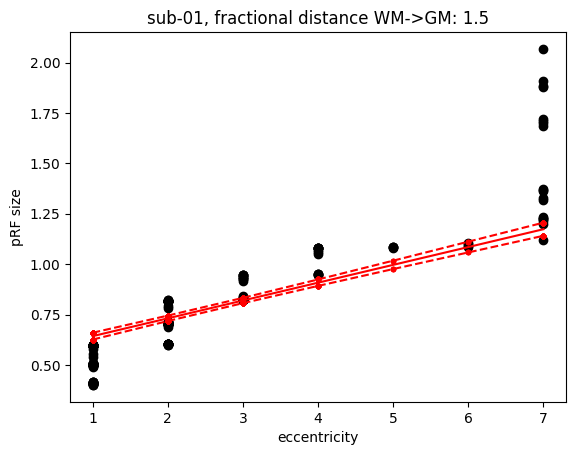

Intercept: 0.554269744697141
t = 49.39, p = 0.00000
Slope: 0.08841730115144548
t = 25.38, p = 0.00000


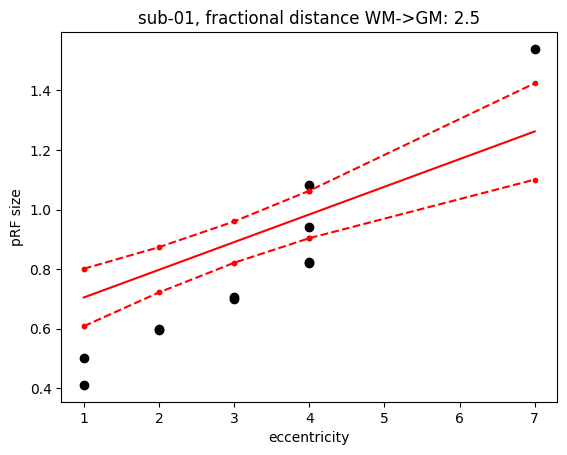

Intercept: 0.6118748305971047
t = 9.69, p = 0.00000
Slope: 0.0928932548855903
t = 5.12, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


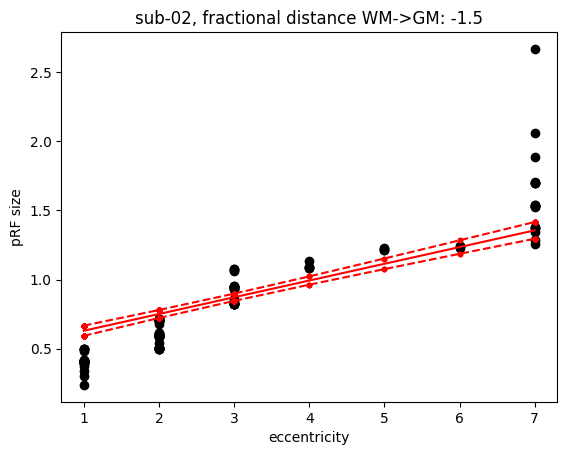

Intercept: 0.5088196649419496
t = 21.18, p = 0.00000
Slope: 0.12094948054566657
t = 17.71, p = 0.00000


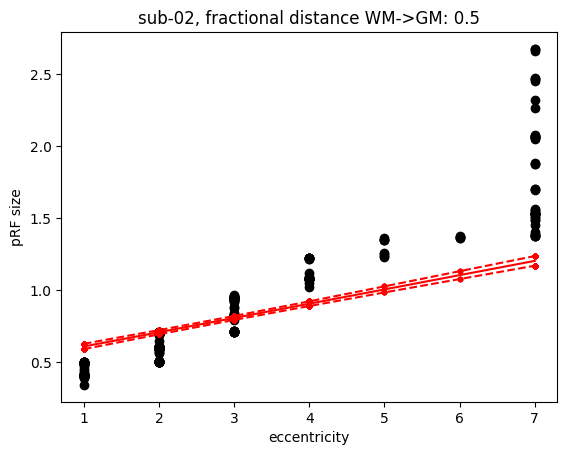

Intercept: 0.5105856227200409
t = 41.41, p = 0.00000
Slope: 0.09910404011282267
t = 26.85, p = 0.00000


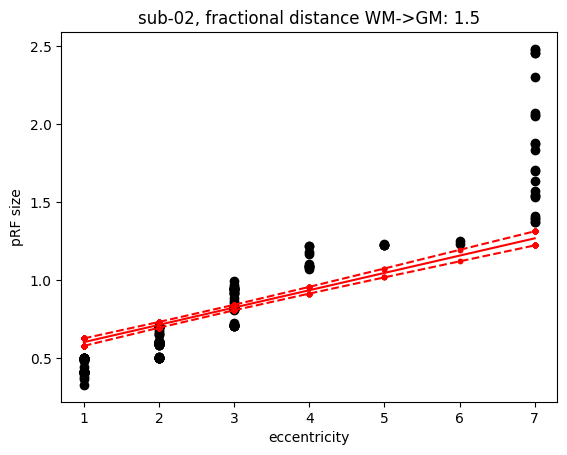

Intercept: 0.4933797162068159
t = 30.88, p = 0.00000
Slope: 0.11070635639240417
t = 22.38, p = 0.00000


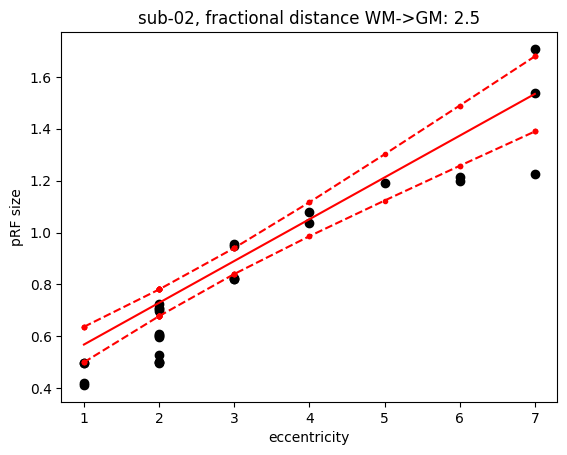

Intercept: 0.40713830819987806
t = 8.61, p = 0.00000
Slope: 0.16101330673127723
t = 10.25, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


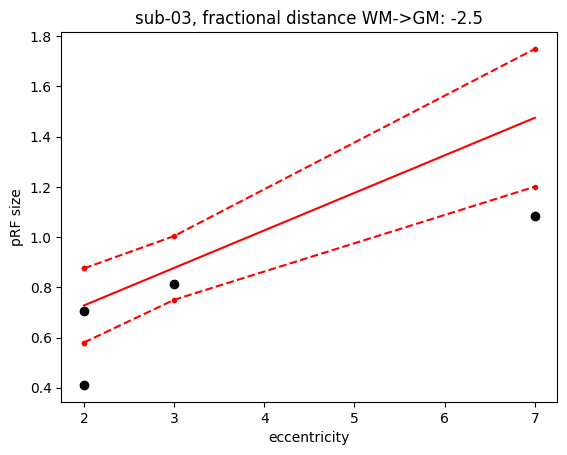

Intercept: 0.42880656141585083
t = 3.50, p = 0.00047
Slope: 0.14948896011806226
t = 4.58, p = 0.00000


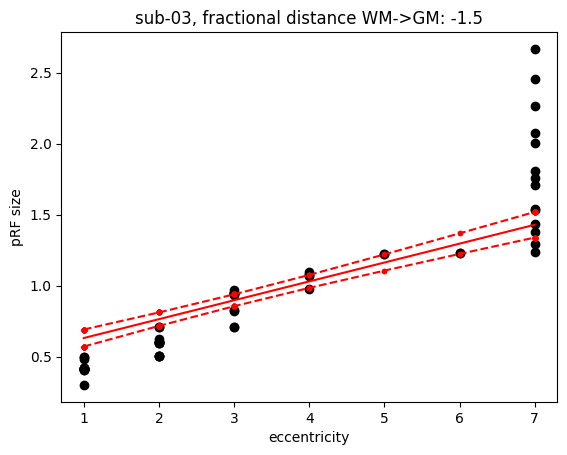

Intercept: 0.4972625682121389
t = 12.81, p = 0.00000
Slope: 0.13302460533779703
t = 12.73, p = 0.00000


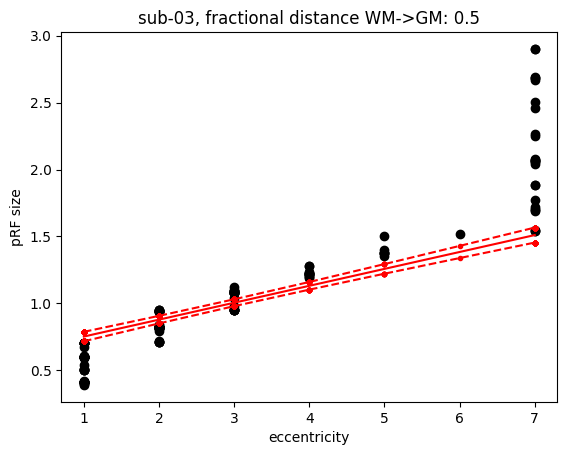

Intercept: 0.6257611197630485
t = 27.47, p = 0.00000
Slope: 0.12635060268199286
t = 20.07, p = 0.00000


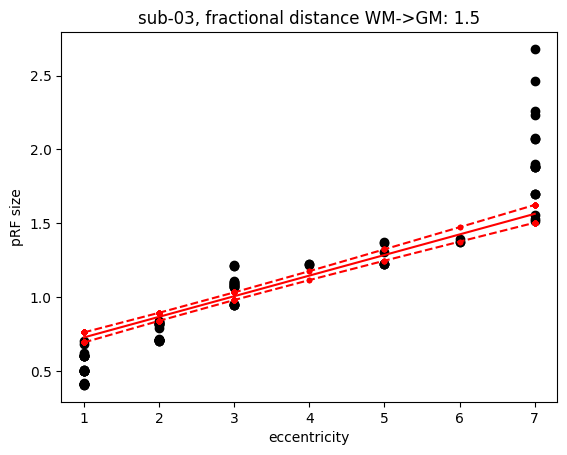

Intercept: 0.586303802347347
t = 26.37, p = 0.00000
Slope: 0.1396177490767991
t = 21.35, p = 0.00000


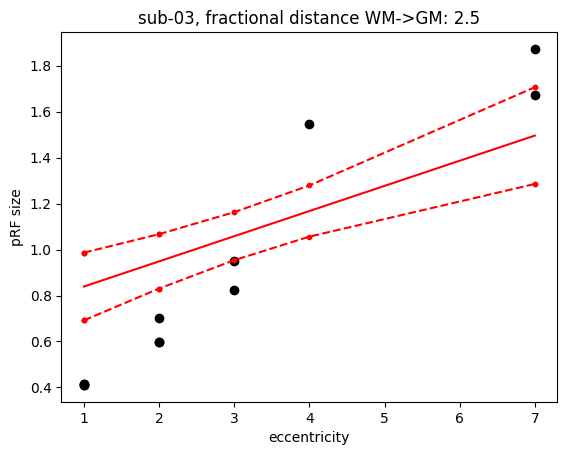

Intercept: 0.7297914004920405
t = 7.77, p = 0.00000
Slope: 0.109397536076726
t = 4.48, p = 0.00001
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


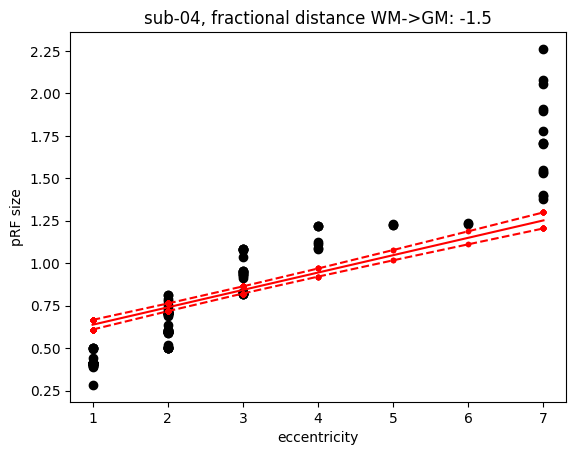

Intercept: 0.5352505762879076
t = 29.02, p = 0.00000
Slope: 0.10240096958088502
t = 19.58, p = 0.00000


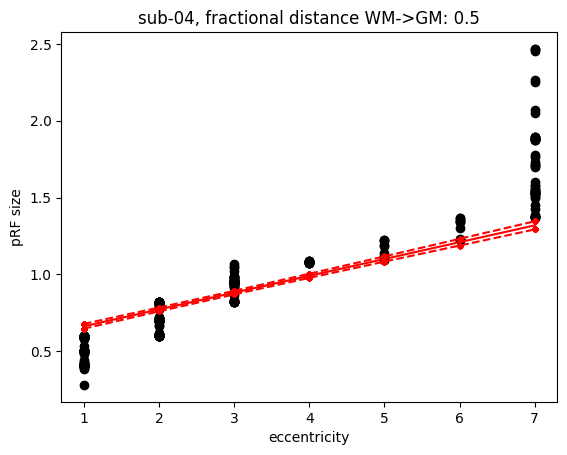

Intercept: 0.5536473461408488
t = 55.10, p = 0.00000
Slope: 0.10937890646805512
t = 37.77, p = 0.00000


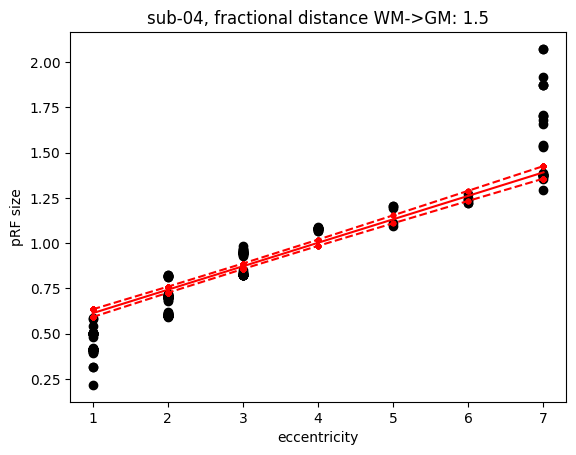

Intercept: 0.4825631483545113
t = 34.67, p = 0.00000
Slope: 0.12977053095230934
t = 33.11, p = 0.00000


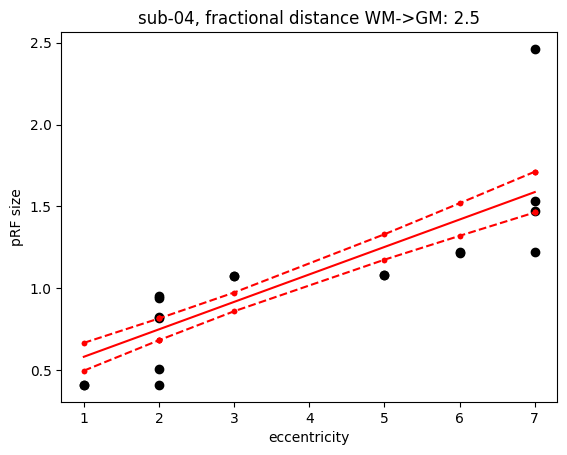

Intercept: 0.4143355755485744
t = 7.51, p = 0.00000
Slope: 0.1676282090752769
t = 11.36, p = 0.00000


In [42]:
for sub_id in range(0,len(subject_list)):
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(subject_list[sub_id])
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    # lh
    idx=df_pRF_per_cortdist.loc[(df_pRF_per_cortdist['sub id'] == subject_list[sub_id]) & 
                                (df_pRF_per_cortdist['roi'] == 'V1') & 
                                (df_pRF_per_cortdist['hem'] == 'lh')].index.tolist()
    lh_sigma = np.stack(df_pRF_per_cortdist.loc[idx, 'pRF size'].to_numpy(), axis=0)
    lh_ecc   = np.stack(df_pRF_per_cortdist.loc[idx, 'ecc'].to_numpy(), axis=0)
    lh_rsq   = np.stack(df_pRF_per_cortdist.loc[idx, 'rsq'].to_numpy(), axis=0)
    lh_cortdist = np.stack(df_pRF_per_cortdist.loc[idx, 'cort dist'].to_numpy(), axis=0)

    # rh
    idx=df_pRF_per_cortdist.loc[(df_pRF_per_cortdist['sub id'] == subject_list[sub_id]) & 
                                (df_pRF_per_cortdist['roi'] == 'V1') & 
                                (df_pRF_per_cortdist['hem'] == 'rh')].index.tolist()
    rh_sigma = np.stack(df_pRF_per_cortdist.loc[idx, 'pRF size'].to_numpy(), axis=0)
    rh_ecc   = np.stack(df_pRF_per_cortdist.loc[idx, 'ecc'].to_numpy(), axis=0)
    rh_rsq   = np.stack(df_pRF_per_cortdist.loc[idx, 'rsq'].to_numpy(), axis=0)
    rh_cortdist = np.stack(df_pRF_per_cortdist.loc[idx, 'cort dist'].to_numpy(), axis=0)

    # concatenate lh&rh
    y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
    x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
    r2       = np.concatenate((lh_rsq.T,rh_rsq.T))
    cortdist = np.concatenate((lh_cortdist.T,rh_cortdist.T))
    
    # threshold by r2
    y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
    x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
    cortdist    = np.atleast_2d(cortdist[r2>rsq_thresh]).T
    
    # threshold by sigma (only positive)
    x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
    cortdist = np.atleast_2d(cortdist[y_sigma>0]).T
    y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

    # threshold by sigma (below threshold)
    x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
    cortdist = np.atleast_2d(cortdist[y_sigma<pRF_thresh]).T
    y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T

    # also remove outliers
    y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
    y_sigma            = y_sigma[idx_or,:]
    x_ecc              = x_ecc[idx_or,:]
    cortdist           = cortdist[idx_or,:]

    # bin eccentricity data
    bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    x_ecc=np.digitize(x_ecc,bins=bins)

    # bin cortical distances
    cortdist=np.digitize(cortdist,cd_bins)
    cortdist_=np.zeros(len(cortdist))
    for n in range(0,len(cortdist)):
        cortdist_[n] = cd_bins[(cortdist[n]-1)]
    cortdist=np.expand_dims(cortdist_, axis=1)
    
    # save full array of sigma, ecc
    y_sigma_all=y_sigma
    x_ecc_all=x_ecc
    
    # loop through binned cortical distances
    for depth_idx in depth:
        y_sigma = y_sigma_all[cortdist==depth_idx]
        x_ecc   = x_ecc_all[cortdist==depth_idx]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_cortdist.loc[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_cortdist['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_cortdist.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])
            continue


        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(x_ecc, y_sigma, test_size=0.1)

        # Fit the model to the training set
        X_train = sm.add_constant(X_train)
        #model = sm.OLS(y_train, X_train).fit()
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

        # Make predictions on the test set
        X_test = sm.add_constant(X_test)
        y_pred = model.predict(X_test)

        # extract the prediction
        pred = model.get_prediction(X_test)

        # extract the intercept and slope
        intercept = model.params[0]
        slope = model.params[1]

        # extract the bootstrapped 95% quantiles and median of the fit
        quantiles = pred.summary_frame(alpha=0.05)
        median = pred.summary_frame(alpha=0.5)

        # plot the model
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_test), 'ko')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_pred), 'r-')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_lower'].values), 'r--.')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_upper'].values), 'r--.')
        plt.xlabel('eccentricity')
        plt.ylabel('pRF size')
        plt.title(subject_list[sub_id]+", fractional distance WM->GM: "+"{0:.2g}".format(depth_idx))
                  #str(depth_idx/10))
        plt.show()

        # print stats
        print(f"Intercept: {intercept}")
        intercept_txt = "t = "+"{:.2f}".format(model.tvalues[0])+", p = "+"{:.5f}".format(model.pvalues[0])
        print(intercept_txt)

        print(f"Slope: {slope}")
        slope_txt = "t = "+"{:.2f}".format(model.tvalues[1])+", p = "+"{:.5f}".format(model.pvalues[1])
        print(slope_txt)

        # get pRF estimate at 2deg
        pRF_est = intercept + target_ecc*slope


        # save stats to df
        idx=df_pRFxecc_stats_cortdist.loc[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_cortdist['depth'] == depth_idx)].index.tolist()
        df_pRFxecc_stats_cortdist.loc[idx, 'intercept-stats'] = pd.Series([intercept_txt]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])
        df_pRFxecc_stats_cortdist.loc[idx, 'slope-stats'] = pd.Series([slope_txt]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])

        df_pRFxecc_stats_cortdist.loc[idx, 'intercept'] = pd.Series([intercept]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])
        df_pRFxecc_stats_cortdist.loc[idx, 'slope'] = pd.Series([slope]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])

        df_pRFxecc_stats_cortdist.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])
        
    

In [43]:
df_pRFxecc_stats_cortdist.head()


sub id  depth  intercept     slope         intercept-stats  \
0  sub-01   -2.5   0.656810  0.011560   t = 4.97, p = 0.00000   
1  sub-01   -1.5   0.535574  0.082901  t = 37.53, p = 0.00000   
2  sub-01   -0.5        NaN       NaN                     NaN   
3  sub-01    0.5   0.537427  0.084927  t = 70.03, p = 0.00000   
4  sub-01    1.5   0.554270  0.088417  t = 49.39, p = 0.00000   

              slope-stats  pRF@2deg  
0   t = 0.35, p = 0.72828  0.679930  
1  t = 18.50, p = 0.00000  0.701376  
2                     NaN       NaN  
3  t = 34.46, p = 0.00000  0.707281  
4  t = 25.38, p = 0.00000  0.731104

#### Plot estimated pRF size at target eccentricity

[0.00648338 0.01983717 0.69911908]
R2 quadratic: 0.9218936199461647
R2 linear: 0.7751779205641642
[ 0.00745973 -0.01258633  0.7147929 ]
R2 quadratic: 0.9927673518802272
R2 linear: 0.3217962908737676
[-1.50351291e-04  4.22074665e-02  8.33034837e-01]
R2 quadratic: 0.94803948953209
R2 linear: 0.9480194642318083
[-0.00455117  0.0050604   0.75975889]
R2 quadratic: 0.4128953977425561
R2 linear: 0.01784401269630964


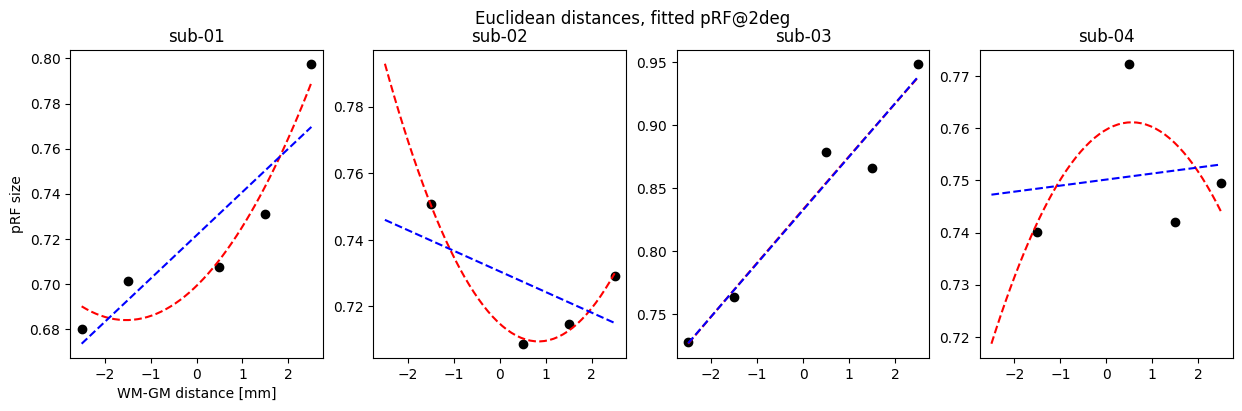

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_cortdist[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_cortdist.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_cortdist.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(-2.5, 2.5, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('WM-GM distance [mm]')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.55, 0.95])
#     axs[sub_id].set_yticks(np.linspace(0.55,0.95,5)) 
#     axs[sub_id].set_ylim([0.6, 0.8])
#     axs[sub_id].set_yticks(np.linspace(0.6,0.8,3)) 

plt.suptitle('Euclidean distances, fitted pRF@2deg')
plt.show()
#     axs[sub_id].set_ylim([0.7, 1.1]4
#     axs[sub_id].set_yticks(np.linspace(0.7,1.1,5))    
    
#     df_pRFxecc_stats_cortdist.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

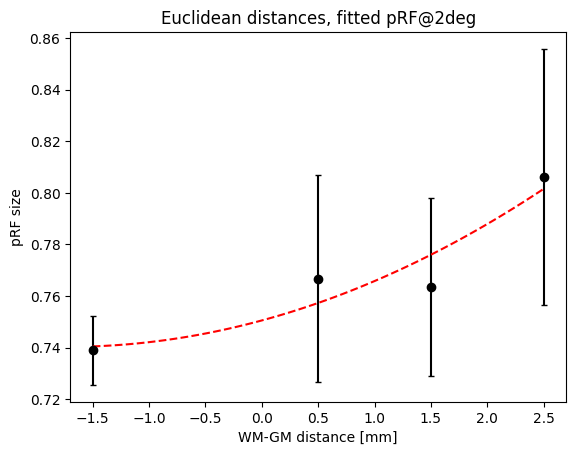

In [45]:
idx      = df_pRFxecc_stats_cortdist[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_cortdist.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_cortdist[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_cortdist['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_cortdist.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_cortdist.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_cortdist.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
# plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('WM-GM distance [mm]')
plt.ylabel('pRF size')


plt.title('Euclidean distances, fitted pRF@2deg')
plt.show()


## Euclidean distances: pRF per cortical layer fitted at manually-defined iso-eccentricity band

#### pRF size at 2deg eccentricity (separately for each cortical depth bin)

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Thresholds

In [46]:
target_ecc = 2
pRF_thresh = max_ecc_deg

Cortical distance bins

In [47]:
cd_bins  = np.linspace(-2.5,2.5,n_layers)
cd_bins

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])

Create a dataframe to save intercept and slope stats

In [48]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = cd_bins.tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_cortdist_2ecc = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [49]:
for sub_id in range(0,len(subject_list)):
    # lh
    idx=df_pRF_per_cortdist_ecc2.loc[(df_pRF_per_cortdist_ecc2['sub id'] == subject_list[sub_id]) & 
                                (df_pRF_per_cortdist_ecc2['hem'] == 'lh') & 
                                (df_pRF_per_cortdist_ecc2['roi'] == 'V1')].index.tolist()
    lh_sigma = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
    lh_ecc   = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
    lh_rsq   = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)
    lh_cortdist = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'cort dist'].to_numpy(), axis=0)

    # rh
    idx=df_pRF_per_cortdist_ecc2.loc[(df_pRF_per_cortdist_ecc2['sub id'] == subject_list[sub_id]) & 
                                (df_pRF_per_cortdist_ecc2['hem'] == 'rh') & 
                                (df_pRF_per_cortdist_ecc2['roi'] == 'V1')].index.tolist()
    rh_sigma = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
    rh_ecc   = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
    rh_rsq   = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)
    rh_cortdist = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'cort dist'].to_numpy(), axis=0)

    # concatenate lh&rh
    y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
    x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
    r2       = np.concatenate((lh_rsq.T,rh_rsq.T))
    cortdist = np.concatenate((lh_cortdist.T,rh_cortdist.T))
    
    # threshold by r2
    y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
    x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
    cortdist    = np.atleast_2d(cortdist[r2>rsq_thresh]).T
    
    # threshold by sigma (only positive)
    x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
    cortdist = np.atleast_2d(cortdist[y_sigma>0]).T
    y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

    # threshold by sigma (below threshold)
    x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
    cortdist = np.atleast_2d(cortdist[y_sigma<pRF_thresh]).T
    y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T

    # also remove outliers
    y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
    y_sigma            = y_sigma[idx_or,:]
    x_ecc              = x_ecc[idx_or,:]
    cortdist           = cortdist[idx_or,:]

    # bin eccentricity data
    bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    x_ecc=np.digitize(x_ecc,bins=bins)

    # bin cortical distances
    cortdist=np.digitize(cortdist,cd_bins)
    cortdist_=np.zeros(len(cortdist))
    for n in range(0,len(cortdist)):
        cortdist_[n] = cd_bins[(cortdist[n]-1)]
    cortdist=np.expand_dims(cortdist_, axis=1)
    
    # save full array of sigma, ecc
    y_sigma_all=y_sigma
    x_ecc_all=x_ecc
    
    # loop through binned cortical distances
    for depth_idx in depth:
        y_sigma = y_sigma_all[cortdist==depth_idx]
        x_ecc   = x_ecc_all[cortdist==depth_idx]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_cortdist_2ecc.loc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_cortdist_2ecc['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_cortdist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_cortdist_2ecc.index[idx])
            continue


        # get pRF estimate at 2deg
        pRF_est = np.mean(y_sigma)


        # save stats to df
        idx=df_pRFxecc_stats_cortdist_2ecc.loc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_cortdist_2ecc['depth'] == depth_idx)].index.tolist()

        df_pRFxecc_stats_cortdist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_cortdist_2ecc.index[idx])
        
    

In [50]:
df_pRFxecc_stats_cortdist_2ecc


sub id  depth  pRF@2deg
0   sub-01   -2.5       NaN
1   sub-01   -1.5  0.741810
2   sub-01   -0.5       NaN
3   sub-01    0.5  0.745948
4   sub-01    1.5  0.750504
5   sub-01    2.5  0.859709
6   sub-02   -2.5       NaN
7   sub-02   -1.5  0.828038
8   sub-02   -0.5       NaN
9   sub-02    0.5  0.751880
10  sub-02    1.5  0.718216
11  sub-02    2.5  0.745129
12  sub-03   -2.5       NaN
13  sub-03   -1.5  0.916098
14  sub-03   -0.5       NaN
15  sub-03    0.5  1.075596
16  sub-03    1.5  1.059825
17  sub-03    2.5  1.158878
18  sub-04   -2.5       NaN
19  sub-04   -1.5  0.853319
20  sub-04   -0.5       NaN
21  sub-04    0.5  0.879744
22  sub-04    1.5  0.865934
23  sub-04    2.5  0.946098

#### Plot estimated pRF size at target eccentricity

[0.0172139  0.00945211 0.7200652 ]
R2 quadratic: 0.9107188719857889
R2 linear: 0.5274830391821532
[ 0.0106407  -0.03293981  0.75625846]
R2 quadratic: 0.9591904219081525
R2 linear: 0.7454524222388804
[-0.00344172  0.05926835  1.01761245]
R2 quadratic: 0.9145471703872797
R2 linear: 0.9096661542996832
[0.00880878 0.01133179 0.85355078]
R2 quadratic: 0.7996363158981309
R2 linear: 0.6091617751131568


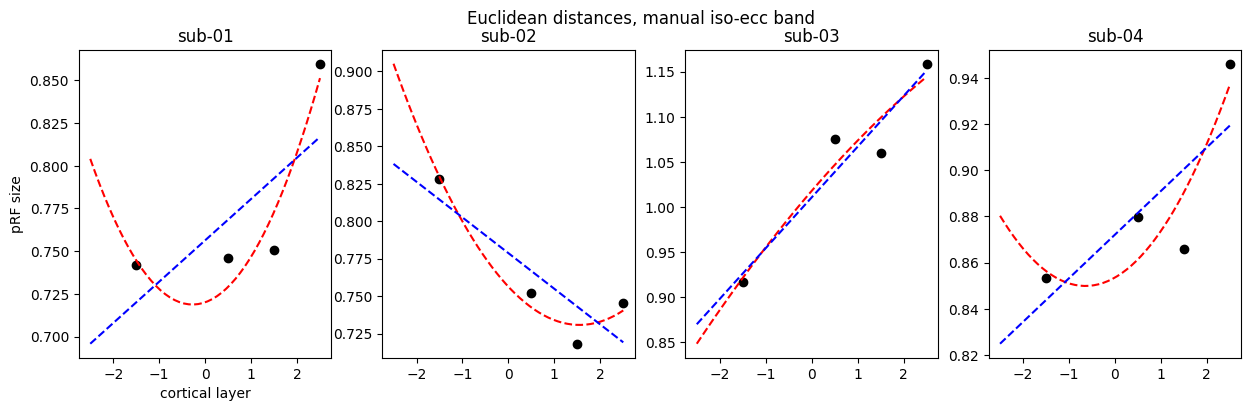

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_cortdist_2ecc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_cortdist_2ecc.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_cortdist_2ecc.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(-2.5, 2.5, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.6, 1.2])
#     axs[sub_id].set_yticks(np.linspace(0.6,1.2,7))   
#     axs[sub_id].set_ylim([0.65, 1.05])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.05,5)) 

plt.suptitle('Euclidean distances, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_cortdist_2ecc.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

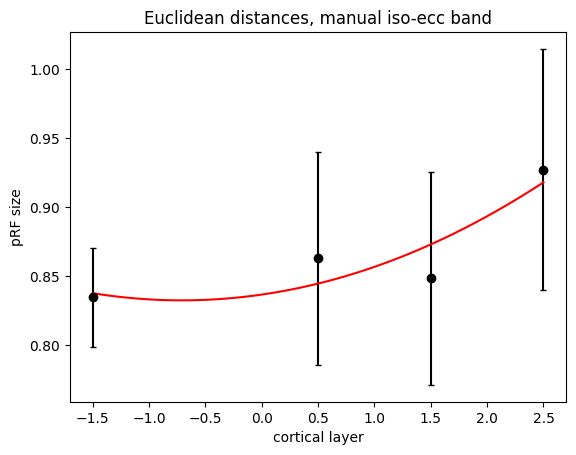

In [52]:
idx      = df_pRFxecc_stats_cortdist_2ecc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_cortdist_2ecc.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_cortdist_2ecc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_cortdist_2ecc['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_cortdist_2ecc.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_cortdist_2ecc.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_cortdist_2ecc.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r-')
#plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.title('Euclidean distances, manual iso-ecc band')
plt.show()


# ######################################################

# ######################################################

# Pooling data from all participants

Thresholds

In [53]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [54]:
n_layers

6

In [55]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth  = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRF_filtered_equivol = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'pRFs': pRF_2deg
})

In [56]:
for depth_idx in depth:
    for sub_id in range(0,len(subject_list)):
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'lh') & 
                                     (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'rh') & 
                                            (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
        print('Nr voxels at layer '+str(depth_idx)+': '+str(len(y_sigma)))
        
        
         # save stats to df
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRF_filtered_equivol['depth'] == depth_idx)].index.tolist()

        df_pRF_filtered_equivol.loc[idx, 'pRFs'] = pd.Series([y_sigma], index=df_pRF_filtered_equivol.index[idx])

        

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 71
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 80
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 40
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 68
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 2.0: 1362
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%

In [57]:
df_pRF_filtered_equivol.head()

sub id  depth                                               pRFs
0  sub-01    1.0  [[0.5008347322401129], [0.7088377653304894], [...
1  sub-01    2.0  [[0.5028093607754424], [0.5983852975705273], [...
2  sub-01    3.0  [[0.4112273942247496], [0.4081223247782812], [...
3  sub-01    4.0  [[0.40599301206943644], [0.7079656235849862], ...
4  sub-01    5.0  [[0.41236410532122064], [0.6951151121038928], ...

In [58]:
all_sigma_list = []
all_pos_list = []

for depth_idx in depth:
    sigmas_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['depth'] == depth_idx)].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
    all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    all_pos_list.append(depth_idx)

In [59]:
pRFsizes = all_sigma_list

Text(0.5, 0, 'Depths (relative index)')

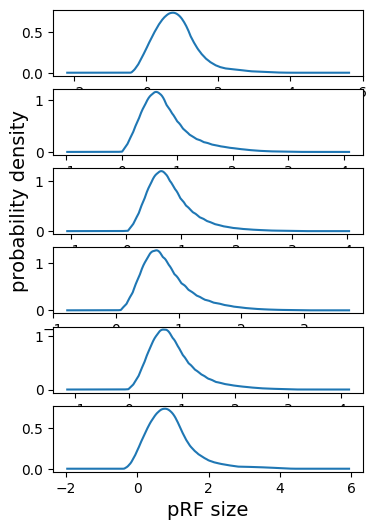

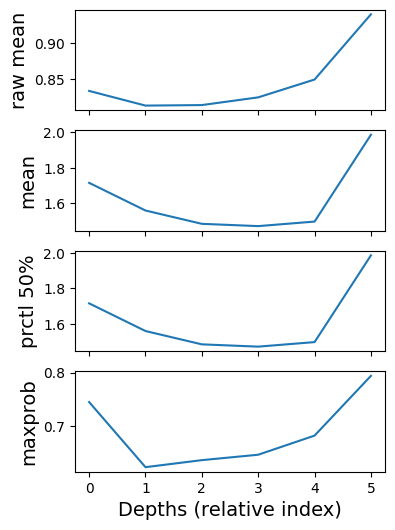

In [60]:
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
ax[2].set_ylabel('probability density', fontsize=14)
ax[len(depth)-1].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

In [61]:
len(all_sigma_list[4])

4390

# ALL ROIS

## Laynii layers: pRF per cortical layer fitted at manually-defined iso-eccentricity band

### Equidistant layering

#### pRF size at 2deg eccentricity (separately for each cortical layer)

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Thresholds

In [62]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [63]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [64]:
subs = [['sub-01']*n_layers*n_rois,['sub-02']*n_layers*n_rois,['sub-03']*n_layers*n_rois,['sub-04']*n_layers*n_rois]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub*n_rois

rois = [['V1']*n_layers,['V2']*n_layers,['V3']*n_layers]
rois = list(itertools.chain(*rois))*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equidist_2ecc = pd.DataFrame({
    'sub id' : subs,
    'roi' : rois,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [65]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        for roi_id in range(0,len(roi_list)):
            # lh
            idx=df_equidist_per_depth_ecc2.loc[(df_equidist_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equidist_per_depth_ecc2['hem'] == 'lh') & 
                                        (df_equidist_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equidist_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            lh_sigma = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            lh_ecc   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            lh_rsq   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # rh
            idx      = df_equidist_per_depth_ecc2.loc[(df_equidist_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equidist_per_depth_ecc2['hem'] == 'rh') & 
                                        (df_equidist_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equidist_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            rh_sigma = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            rh_ecc   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            rh_rsq   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # concatenate lh&rh
            y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
            x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
            r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

    #         y_sigma = lh_sigma
    #         x_ecc = lh_ecc
    #         r2 = lh_rsq

            # threshold by r2
            y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
            x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T

            # threshold by sigma (only positive)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

            # threshold by sigma (below threshold)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T


            # also remove outliers
            y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
            y_sigma            = y_sigma[idx_or,:]
            x_ecc              = x_ecc[idx_or,:]

            # bin eccentricity data
            bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
            x_ecc=np.digitize(x_ecc,bins=bins)

        #     # random shuffle
        #     shuffle_indices = np.random.permutation(len(y_sigma))
        #     y_sigma = y_sigma[shuffle_indices]
        #     x_ecc = x_ecc[shuffle_indices]

            if len(y_sigma) < 30:
                idx=df_pRFxecc_stats_equidist_2ecc.loc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equidist_2ecc['depth'] == depth_idx) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()
                df_pRFxecc_stats_equidist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equidist_2ecc.index[idx])
                continue


            # get pRF estimate at 2deg
            pRF_est = np.mean(y_sigma)


            # save stats to df
            idx=df_pRFxecc_stats_equidist_2ecc.loc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equidist_2ecc['depth'] == depth_idx) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()

            df_pRFxecc_stats_equidist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equidist_2ecc.index[idx])

    

In [66]:
df_pRFxecc_stats_equidist_2ecc


sub id roi  depth  pRF@2deg
0   sub-01  V1    1.0  0.650550
1   sub-01  V1    2.0  0.718650
2   sub-01  V1    3.0  0.748120
3   sub-01  V1    4.0  0.744522
4   sub-01  V1    5.0  0.781408
..     ...  ..    ...       ...
67  sub-04  V3    2.0  1.094105
68  sub-04  V3    3.0  0.975461
69  sub-04  V3    4.0  0.938599
70  sub-04  V3    5.0  0.968209
71  sub-04  V3    6.0       NaN

[72 rows x 4 columns]

#### Plot estimated pRF size at target eccentricity

[0.00545844 0.00337587 0.66339154]
R2 quadratic: 0.8851853443924428
R2 linear: 0.853803306110198
[ 0.02143995 -0.13001905  1.00586814]
R2 quadratic: 0.8866969036347031
R2 linear: 0.2580010170770508
[-0.00928388  0.08236924  0.79692416]
R2 quadratic: 0.5683293247167349
R2 linear: 0.48587744690116186
[ 0.00301458 -0.00096039  0.69969307]
R2 quadratic: 0.5798966227849043
R2 linear: 0.553448270920222
[-0.00392004  0.02396166  0.82155444]
R2 quadratic: 0.08238044590555638
R2 linear: 0.022210457420461682
[-0.01184722  0.08676507  0.77907839]
R2 quadratic: 0.7648626978884973
R2 linear: 0.08856181641541527
[-0.00612594  0.04074467  1.01848529]
R2 quadratic: 0.15703961536311029
R2 linear: 0.02073322775966524
[-0.00982678  0.07367982  1.07111355]
R2 quadratic: 0.26211522114870955
R2 linear: 0.06200156848563976
[-0.00140246  0.01333799  1.10542685]
R2 quadratic: 0.006126592655795737
R2 linear: 0.005436484486880944
[-0.00899772  0.08134125  0.71092277]
R2 quadratic: 0.8015420893997789
R2 linear: 0

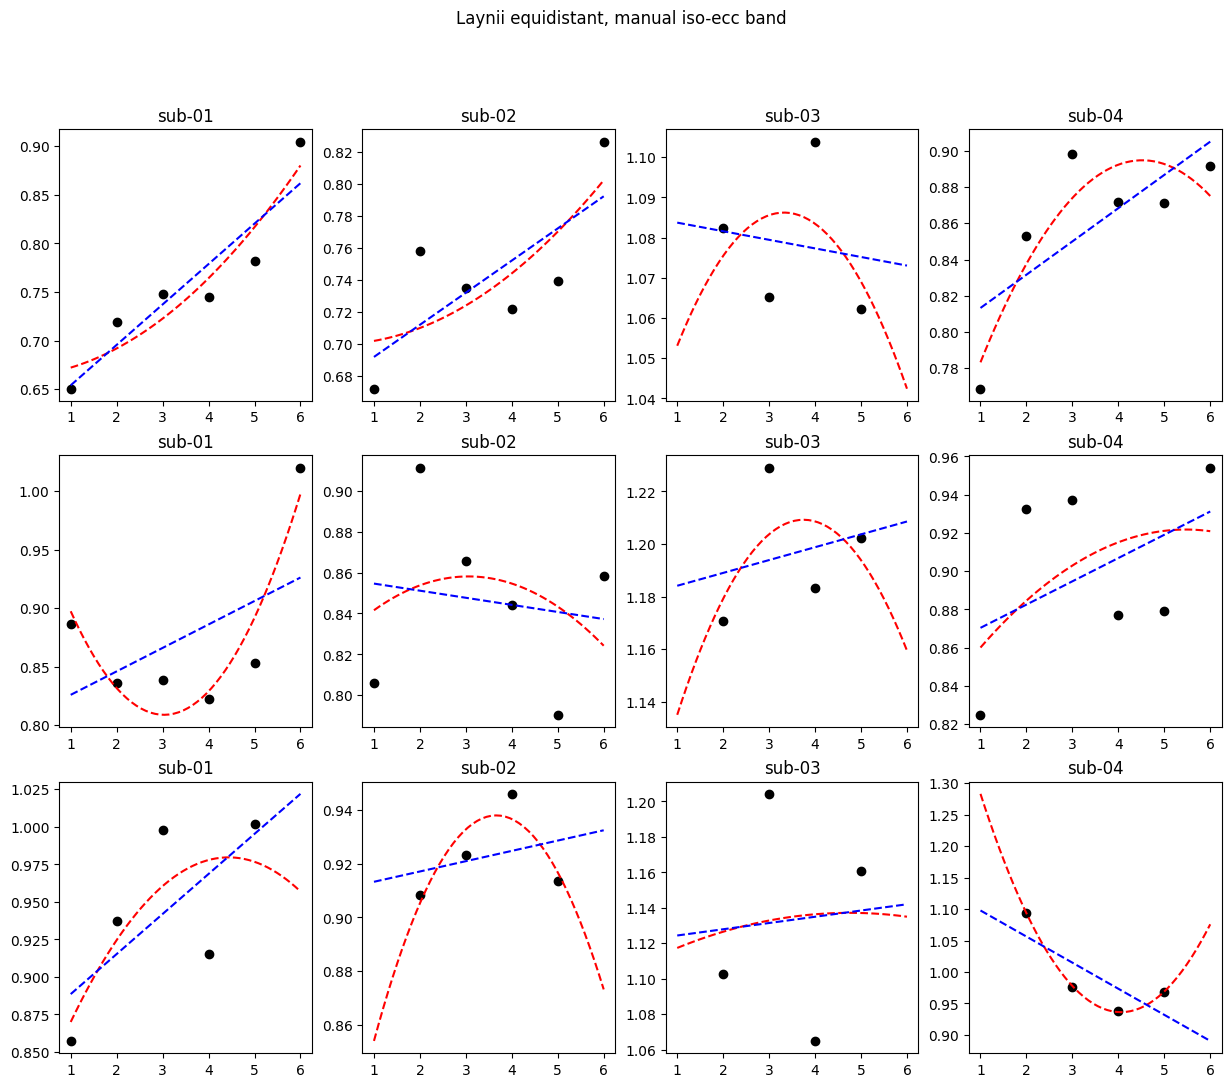

In [67]:
fig, axs = plt.subplots(nrows=len(roi_list), ncols=len(subject_list), figsize=(15, 12))

for sub_id in range(0,len(subject_list)):
    for roi_id in range(0,len(roi_list)):
        idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        depth    = df_pRFxecc_stats_equidist_2ecc.loc[idx,'depth'].values
        pRF_2deg = df_pRFxecc_stats_equidist_2ecc.loc[idx,'pRF@2deg'].values

        # omit nans
        idx = np.isfinite(pRF_2deg)
        pRF_2deg = pRF_2deg[idx]
        depth=depth[idx]

        # Fit the quadratic equation
        coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)

        # Fit the linear equation
        coefs_linear = np.polyfit(depth, pRF_2deg, 1)

        # Print the coefficients
        print(coefs_quadratic)

        # Create a polynomial function from the coefficients
        f_quadratic = np.poly1d(coefs_quadratic)
        f_linear = np.poly1d(coefs_linear)

        # calculate the R-squared
        r_squared = r2_score(pRF_2deg, f_quadratic(depth))
        print(f"R2 quadratic: {r_squared}")
        r_squared = r2_score(pRF_2deg, f_linear(depth))
        print(f"R2 linear: {r_squared}")

        # quadratic model fit
        #x = np.linspace(0.2, 0.9, 50)
        x = np.linspace(1, n_layers, 50)
        y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
        y_linear = coefs_linear[0]*x + coefs_linear[1]

        # plot the model
        axs[roi_id,sub_id].plot(depth,pRF_2deg,'ko')
        axs[roi_id,sub_id].plot(x,y_quadratic,'r--')
        axs[roi_id,sub_id].plot(x,y_linear,'b--')
        if sub_id == 0 & roi_id == len(roi_list)-1:
            axs[roi_id,sub_id].set_xlabel('cortical layer')
            axs[roi_id,sub_id].set_ylabel('pRF size')
        axs[roi_id,sub_id].set_title(subject_list[sub_id])
    #     axs[sub_id].set_ylim([0.65, 1.15])
    #     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6)) 
#         axs[roi_id,sub_id].set_ylim([0.6, 1.1])
#         axs[roi_id,sub_id].set_yticks(np.linspace(0.6,1.1,6)) 
    

plt.suptitle('Laynii equidistant, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_equidist_2ecc.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

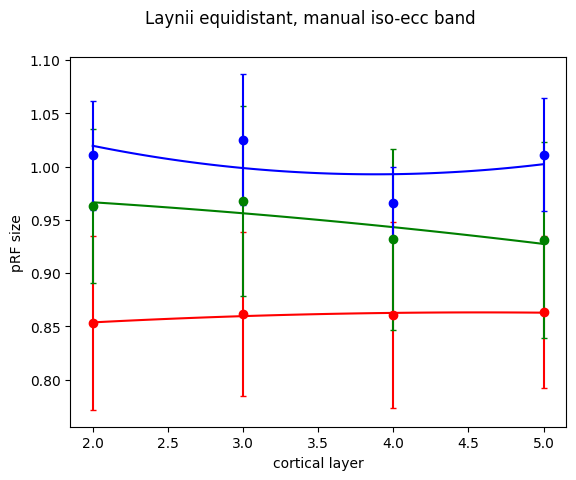

In [68]:
for roi_id in range(0,len(roi_list)):       
    idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[0]) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()
    depth    = df_pRFxecc_stats_equidist_2ecc.loc[idx,'depth'].values
    #depth    = depth[1:]
    pRF_2deg = np.empty((len(depth),len(subject_list)))

    for sub_id in range(0,len(subject_list)):
        idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                            (df_pRFxecc_stats_equidist_2ecc['depth'] >= np.min(depth)) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        pRF_2deg[:,sub_id] = df_pRFxecc_stats_equidist_2ecc.loc[idx,'pRF@2deg'].values


    # omit nans
    idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
    pRF_2deg = pRF_2deg[idx,:]
    depth=depth[idx]

    # Transform the independent variable into a set of polynomial features
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(depth.reshape(-1,1))

    # Create and fit the model
    model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

    # Make predictions
    X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = model.predict(X_plot_poly)

    y_mean = y_plot.mean(axis=1)
    y_median = np.median(y_plot,axis=1)


    # data for plot
    depth_plot    = df_pRFxecc_stats_equidist_2ecc.loc[:,'depth'].values
    pRF_2deg_plot = df_pRFxecc_stats_equidist_2ecc.loc[:,'pRF@2deg'].values


    # plot
    if roi_id == 0:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='ro')
        plt.plot(X_plot,y_mean,'r-')
    elif roi_id == 1:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='go')
        plt.plot(X_plot,y_mean,'g-')
    elif roi_id == 2:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='bo')
        plt.plot(X_plot,y_mean,'b-')
   
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.suptitle('Laynii equidistant, manual iso-ecc band')
plt.show()


### Equivolumetric layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Set number of layers, eccentricities, subjects, hemispheres

Thresholds

In [69]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [70]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [71]:
subs = [['sub-01']*n_layers*n_rois,['sub-02']*n_layers*n_rois,['sub-03']*n_layers*n_rois,['sub-04']*n_layers*n_rois]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub*n_rois

rois = [['V1']*n_layers,['V2']*n_layers,['V3']*n_layers]
rois = list(itertools.chain(*rois))*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol_2ecc = pd.DataFrame({
    'sub id' : subs,
    'roi' : rois,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [72]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        for roi_id in range(0,len(roi_list)):
            # lh
            idx=df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'lh') & 
                                        (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            lh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            lh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            lh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # rh
            idx      = df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'rh') & 
                                        (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            rh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            rh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            rh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # concatenate lh&rh
            y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
            x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
            r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

    #         y_sigma = lh_sigma
    #         x_ecc = lh_ecc
    #         r2 = lh_rsq

            # threshold by r2
            y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
            x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T

            # threshold by sigma (only positive)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

            # threshold by sigma (below threshold)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T


            # also remove outliers
            y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
            y_sigma            = y_sigma[idx_or,:]
            x_ecc              = x_ecc[idx_or,:]

            # bin eccentricity data
            bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
            x_ecc=np.digitize(x_ecc,bins=bins)

        #     # random shuffle
        #     shuffle_indices = np.random.permutation(len(y_sigma))
        #     y_sigma = y_sigma[shuffle_indices]
        #     x_ecc = x_ecc[shuffle_indices]

            if len(y_sigma) < 30:
                idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equivol_2ecc['depth'] == depth_idx) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
                df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])
                continue


            # get pRF estimate at 2deg
            pRF_est = np.mean(y_sigma)
            #pRF_est = np.median(y_sigma)


            # save stats to df
            idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equivol_2ecc['depth'] == depth_idx) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()

            df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])

    

In [73]:
df_pRFxecc_stats_equivol_2ecc.head()


sub id roi  depth  pRF@2deg
0  sub-01  V1    1.0  0.669891
1  sub-01  V1    2.0  0.717945
2  sub-01  V1    3.0  0.734753
3  sub-01  V1    4.0  0.745139
4  sub-01  V1    5.0  0.789512

#### Plot estimated pRF size at target eccentricity

[-0.00098458  0.03255106  0.64462553]
R2 quadratic: 0.9431116400199474
R2 linear: 0.9413120286728965
[-6.47584961e-04  3.34639887e-03  8.32638637e-01]
R2 quadratic: 0.08407759382331459
R2 linear: 0.027839664412945053
[-0.00407554  0.02214873  0.93974623]
R2 quadratic: 0.08117827158014324
R2 linear: 0.061199880627780257
[ 0.01424853 -0.08571659  0.84684532]
R2 quadratic: 0.8932023707021954
R2 linear: 0.278911284404308
[-0.00231236 -0.01642955  0.93187492]
R2 quadratic: 0.8646046714715954
R2 linear: 0.8576136688622162
[-0.01309114  0.08925964  0.78872482]
R2 quadratic: 0.7499134111243558
R2 linear: 0.029714187245487578
[-0.00716969  0.06682274  0.93530783]
R2 quadratic: 0.3545159737712348
R2 linear: 0.30864765664221794
[-0.01518504  0.08980237  1.07411459]
R2 quadratic: 0.2833535019337641
R2 linear: 0.0014934833550747095
[-0.03261239  0.22122212  0.78580783]
R2 quadratic: 0.981551863151851
R2 linear: 0.054385044825359996
[ 0.00147679 -0.00666452  0.87687531]
R2 quadratic: 0.1431293590504

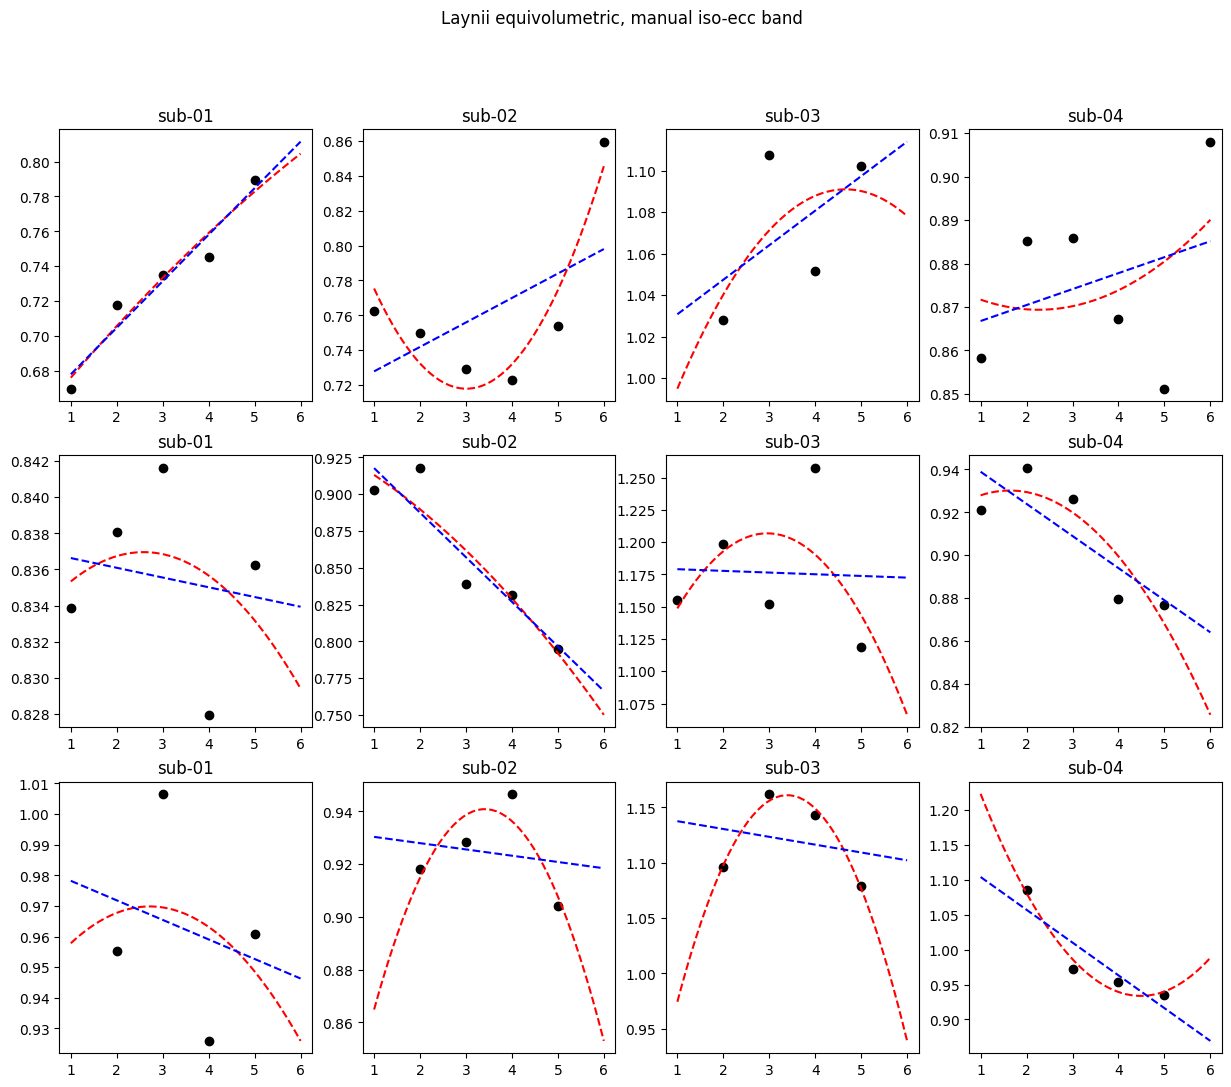

In [74]:
fig, axs = plt.subplots(nrows=len(roi_list), ncols=len(subject_list), figsize=(15, 12))

for sub_id in range(0,len(subject_list)):
    for roi_id in range(0,len(roi_list)):
        idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'depth'].values
        pRF_2deg = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values

        # omit nans
        idx = np.isfinite(pRF_2deg)
        pRF_2deg = pRF_2deg[idx]
        depth=depth[idx]

        # Fit the quadratic equation
        coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)

        # Fit the linear equation
        coefs_linear = np.polyfit(depth, pRF_2deg, 1)

        # Print the coefficients
        print(coefs_quadratic)

        # Create a polynomial function from the coefficients
        f_quadratic = np.poly1d(coefs_quadratic)
        f_linear = np.poly1d(coefs_linear)

        # calculate the R-squared
        r_squared = r2_score(pRF_2deg, f_quadratic(depth))
        print(f"R2 quadratic: {r_squared}")
        r_squared = r2_score(pRF_2deg, f_linear(depth))
        print(f"R2 linear: {r_squared}")

        # quadratic model fit
        #x = np.linspace(0.2, 0.9, 50)
        x = np.linspace(1, n_layers, 50)
        y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
        y_linear = coefs_linear[0]*x + coefs_linear[1]

        # plot the model
        axs[roi_id,sub_id].plot(depth,pRF_2deg,'ko')
        axs[roi_id,sub_id].plot(x,y_quadratic,'r--')
        axs[roi_id,sub_id].plot(x,y_linear,'b--')
        if sub_id == 0 & roi_id == len(roi_list)-1:
            axs[roi_id,sub_id].set_xlabel('cortical layer')
            axs[roi_id,sub_id].set_ylabel('pRF size')
        axs[roi_id,sub_id].set_title(subject_list[sub_id])
    #     axs[sub_id].set_ylim([0.65, 1.15])
    #     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6)) 
#         axs[roi_id,sub_id].set_ylim([0.6, 1.1])
#         axs[roi_id,sub_id].set_yticks(np.linspace(0.6,1.1,6)) 
    

plt.suptitle('Laynii equivolumetric, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_equivol_2ecc.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equivol_per_depth['hem'] == 'lh') & 
#                                 (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

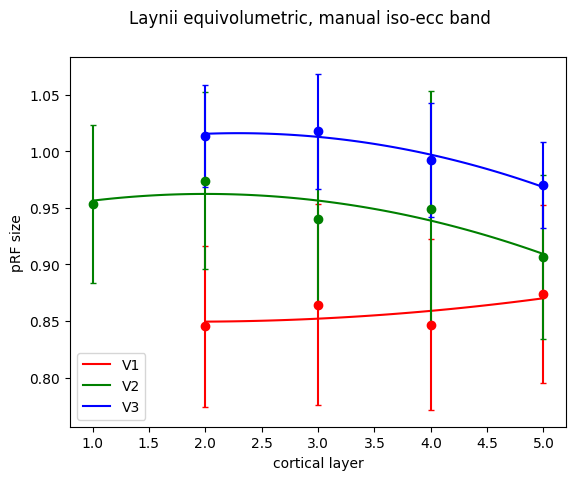

In [75]:
for roi_id in range(0,len(roi_list)):       
    idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[0]) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'depth'].values
    #depth    = depth[1:]
    pRF_2deg = np.empty((len(depth),len(subject_list)))

    for sub_id in range(0,len(subject_list)):
        idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                            (df_pRFxecc_stats_equivol_2ecc['depth'] >= np.min(depth)) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values


    # omit nans
    idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
    pRF_2deg = pRF_2deg[idx,:]
    depth=depth[idx]

    # Transform the independent variable into a set of polynomial features
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(depth.reshape(-1,1))

    # Create and fit the model
    model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

    # Make predictions
    X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = model.predict(X_plot_poly)

    y_mean = y_plot.mean(axis=1)
    y_median = np.median(y_plot,axis=1)


    # data for plot
    depth_plot    = df_pRFxecc_stats_equivol_2ecc.loc[:,'depth'].values
    pRF_2deg_plot = df_pRFxecc_stats_equivol_2ecc.loc[:,'pRF@2deg'].values


    # plot
    if roi_id == 0:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='ro')
        line1=plt.plot(X_plot,y_mean,'r-')
    elif roi_id == 1:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='go')
        line2=plt.plot(X_plot,y_mean,'g-')
    elif roi_id == 2:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='bo')
        line3=plt.plot(X_plot,y_mean,'b-')
        
   
plt.legend(['V1', 'V2', 'V3'])

plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.suptitle('Laynii equivolumetric, manual iso-ecc band')
plt.show()


# Pooling and max prob of fitted distribution

Set number of layers, eccentricities, subjects, hemispheres

Thresholds

In [76]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [77]:
subs = [['sub-01']*n_layers*n_rois,['sub-02']*n_layers*n_rois,['sub-03']*n_layers*n_rois,['sub-04']*n_layers*n_rois]
subs = list(itertools.chain(*subs))

depth  = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub*n_rois

rois = [['V1']*n_layers,['V2']*n_layers,['V3']*n_layers]
rois = list(itertools.chain(*rois))*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))

cortdist = np.empty((1,len(subs),)).tolist()
cortdist = list(itertools.chain(*cortdist))


df_pRF_filtered_equivol = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'roi' : rois,
    'pRFs': pRF_2deg,
    'cortdist': cortdist
})

In [78]:
for roi_id in range(0,len(roi_list)):  
    for depth_idx in depth:
        for sub_id in range(0,len(subject_list)):
            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            print(subject_list[sub_id])
            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            # lh
            idx=df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'lh') & 
                                         (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            lh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            lh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            lh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)
            lh_cortdist = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'cortdist'].to_numpy(), axis=0)

            # rh
            idx      = df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'rh') & 
                                                (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            rh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            rh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            rh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)
            rh_cortdist = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'cortdist'].to_numpy(), axis=0)

            # concatenate lh&rh
            y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
            x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
            r2       = np.concatenate((lh_rsq.T,rh_rsq.T))
            cortdist = np.concatenate((lh_cortdist.T,rh_cortdist.T))

            # threshold by r2
            y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
            x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
            cortdist = np.atleast_2d(cortdist[r2>rsq_thresh]).T

            # threshold by sigma (only positive)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
            cortdist    = np.atleast_2d(cortdist[y_sigma>0]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

            # threshold by sigma (below threshold)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
            cortdist = np.atleast_2d(cortdist[y_sigma<pRF_thresh]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T


            # also remove outliers
            y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
            y_sigma            = y_sigma[idx_or,:]
            x_ecc              = x_ecc[idx_or,:]
            cortdist           = cortdist[idx_or,:]

            print('Nr voxels at layer '+str(depth_idx)+': '+str(len(y_sigma)))


             # save stats to df
            idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                    (df_pRF_filtered_equivol['depth'] == depth_idx) &
                                    (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()

            df_pRF_filtered_equivol.loc[idx, 'pRFs'] = pd.Series([y_sigma], index=df_pRF_filtered_equivol.index[idx])
            df_pRF_filtered_equivol.loc[idx, 'cortdist'] = pd.Series([cortdist], index=df_pRF_filtered_equivol.index[idx])
        

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 31
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 46
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 12
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 32
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 2.0: 649
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%

Nr voxels at layer 6.0: 6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 6.0: 0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 6.0: 2


In [79]:
df_pRF_filtered_equivol.head()

sub id  depth roi                                               pRFs  \
0  sub-01    1.0  V1  [[0.5008347322401129], [0.4144347165296704], [...   
1  sub-01    2.0  V1  [[0.5028093607754424], [0.5983852975705273], [...   
2  sub-01    3.0  V1  [[0.4112273942247496], [0.4081223247782812], [...   
3  sub-01    4.0  V1  [[0.7079656235849862], [0.8199405823223472], [...   
4  sub-01    5.0  V1  [[0.41236410532122064], [0.6951151121038928], ...   

                                            cortdist  
0  [[0.8], [0.8], [0.8], [0.8], [0.8], [0.8], [0....  
1  [[1.1313708498984762], [0.8], [0.8], [0.8], [0...  
2  [[1.6], [1.6], [1.6], [1.3856406460551018], [1...  
3  [[1.6], [1.6], [1.3856406460551018], [1.131370...  
4  [[2.4000000000000004], [2.4000000000000004], [...

In [80]:
V1_all_sigma_list = []
V1_all_pos_list = []
V1_cortdist_list = []
roi_id = 0

for depth_idx in depth:
    sigmas_thisdepth = []
    cortdist_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['depth'] == depth_idx) &
                                        (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        cortdist_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'cortdist'].values[0])
    V1_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    V1_all_pos_list.append(depth_idx)
    V1_cortdist_list.append(np.array(flatten(cortdist_thisdepth)))
    
    
V2_all_sigma_list = []
V2_all_pos_list = []
V2_cortdist_list = []
roi_id = 1

for depth_idx in depth:
    sigmas_thisdepth = []
    cortdist_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['depth'] == depth_idx) &
                                        (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        cortdist_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'cortdist'].values[0])
    V2_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    V2_all_pos_list.append(depth_idx)
    V2_cortdist_list.append(np.array(flatten(cortdist_thisdepth)))

V3_all_sigma_list = []
V3_all_pos_list = []
V3_cortdist_list = []
roi_id = 2

for depth_idx in depth:
    sigmas_thisdepth = []
    cortdist_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['depth'] == depth_idx) &
                                        (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        cortdist_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'cortdist'].values[0])
    V3_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    V3_all_pos_list.append(depth_idx)
    V3_cortdist_list.append(np.array(flatten(cortdist_thisdepth)))

In [81]:
np.save('V1_all_sigma_list_'+prf_model,V1_all_sigma_list)
np.save('V2_all_sigma_list_'+prf_model,V2_all_sigma_list)
np.save('V3_all_sigma_list_'+prf_model,V3_all_sigma_list)

np.save('V1_cortdist_list_'+prf_model,V1_cortdist_list)
np.save('V2_cortdist_list_'+prf_model,V2_cortdist_list)
np.save('V3_cortdist_list_'+prf_model,V3_cortdist_list)

/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [82]:
# np.histogram(V3_cortdist_list[1])

## Bootstrapping

In [83]:
# non-parametric fit parameters
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

# Set the number of bootstrap samples, depths
n_boot = 1000
n_depth = len(depth)


In [84]:
try:
    V1_maxprobs=np.load('V1_maxprobs_'+prf_model+'.npy')
    V2_maxprobs=np.load('V2_maxprobs_'+prf_model+'.npy')
    V3_maxprobs=np.load('V3_maxprobs_'+prf_model+'.npy')
except:
    
    # Create an array to store the maximum probability values
    V1_maxprobs = np.zeros([n_depth,n_boot])
    V2_maxprobs = np.zeros([n_depth,n_boot])
    V3_maxprobs = np.zeros([n_depth,n_boot])


    # Generate bootstrap samples and calculate the maximum probability value for each sample
    # V1
    pRFsizes = V1_all_sigma_list
    print('V1 bootstrapping')
    for n in range(0,len(depth)):
            data = np.squeeze(pRFsizes[n])
            print('depth '+str(n))
            for i in range(n_boot):
                sample = np.random.choice(data, size=len(data), replace=True)

                dens = sm.nonparametric.KDEUnivariate(sample)
                dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)

                s = dens.support
                idx = np.argmax(dens.density)
                V1_maxprobs[n,i] = s[idx]

    # V2
    pRFsizes = V2_all_sigma_list
    print('V2 bootstrapping')

    for n in range(0,len(depth)):
            data = np.squeeze(pRFsizes[n])
            print('depth '+str(n))
            for i in range(n_boot):
                sample = np.random.choice(data, size=len(data), replace=True)

                dens = sm.nonparametric.KDEUnivariate(sample)
                dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)

                s = dens.support
                idx = np.argmax(dens.density)
                V2_maxprobs[n,i] = s[idx]

    # V3
    pRFsizes = V3_all_sigma_list
    print('V3 bootstrapping')

    for n in range(0,len(depth)):
            data = np.squeeze(pRFsizes[n])
            print('depth '+str(n))
            for i in range(n_boot):
                sample = np.random.choice(data, size=len(data), replace=True)

                dens = sm.nonparametric.KDEUnivariate(sample)
                dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)

                s = dens.support
                idx = np.argmax(dens.density)
                V3_maxprobs[n,i] = s[idx]

    np.save('V1_maxprobs_'+prf_model,V1_maxprobs)
    np.save('V2_maxprobs_'+prf_model,V2_maxprobs)
    np.save('V3_maxprobs_'+prf_model,V3_maxprobs)

V1 bootstrapping
depth 0
depth 1
depth 2
depth 3
depth 4
depth 5
V2 bootstrapping
depth 0
depth 1
depth 2
depth 3
depth 4
depth 5
V3 bootstrapping
depth 0
depth 1
depth 2
depth 3
depth 4
depth 5


## V1

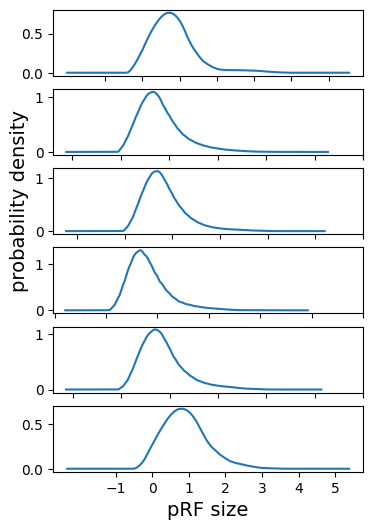

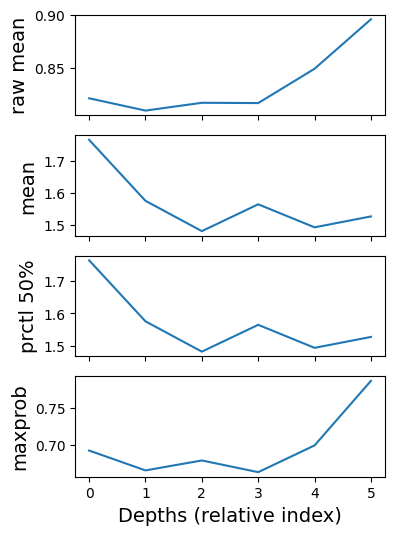

In [85]:
pRFsizes = V1_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

# CI array init
V1_CI_lower = np.zeros([n_depth,])
V1_CI_upper = np.zeros([n_depth,])
V1_SE = np.zeros([n_depth,])
V1_SD = np.zeros([n_depth,])
V1_HDI = np.zeros([n_depth,2])


fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    ax[n].set_xticks(np.arange(-1,6))
    if n != len(depth)-1 :
        ax[n].set_xticklabels([])
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
    
    # get 95% HDI (high density interval)
    data = np.array(X)
    data = data[np.isfinite(data)]
    
    density = dens.density
    kde = gaussian_kde(data)
    
    # Evaluate the density function at a range of values
    x = np.linspace(s.min(), s.max(), 1000)
    pdf = kde(x)
    
    # Find the 95% HDI
    q = 0.95
    cdf = np.cumsum(pdf) / np.sum(pdf)
    idx1 = np.argmin(np.abs(cdf - (1 - q) / 2))
    idx2 = np.argmin(np.abs(cdf - (1 + q) / 2))
    V1_HDI[n,:] = [x[idx1], x[idx2]]

    # get bootstrapped CI's
    V1_CI_lower[n] = np.percentile(V1_maxprobs[n,:], 2.5)
    V1_CI_upper[n] = np.percentile(V1_maxprobs[n,:], 97.5)
    
    V1_SE[n] = np.std(V1_maxprobs[n,:], ddof=1) / np.sqrt(n_boot)
    V1_SD[n] = np.std(V1_maxprobs[n,:], ddof=1) 
    
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V1_sigmas=sigmas

## V2

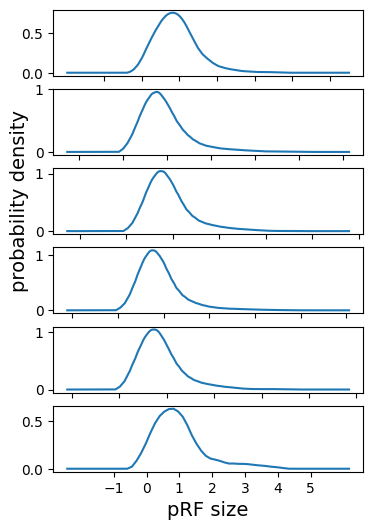

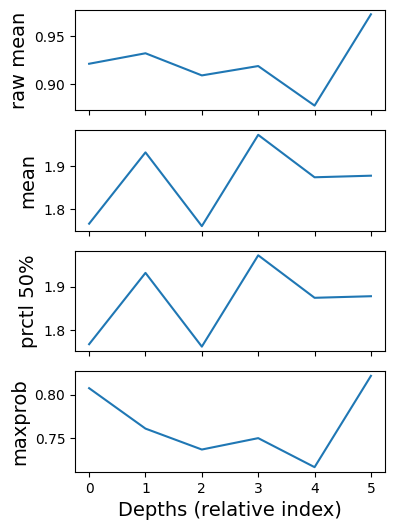

In [86]:
pRFsizes = V2_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

# CI array init
V2_CI_lower = np.zeros([n_depth,])
V2_CI_upper = np.zeros([n_depth,])
V2_SE = np.zeros([n_depth,])
V2_SD = np.zeros([n_depth,])
V2_HDI = np.zeros([n_depth,2])

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    ax[n].set_xticks(np.arange(-1,6))
    if n != len(depth)-1 :
        ax[n].set_xticklabels([])
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
    
    # get 95% HDI (high density interval)
    data = np.array(X)
    data = data[np.isfinite(data)]
    
    density = dens.density
    kde = gaussian_kde(data)
    
    # Evaluate the density function at a range of values
    x = np.linspace(s.min(), s.max(), 1000)
    pdf = kde(x)
    
    # Find the 95% HDI
    q = 0.95
    cdf = np.cumsum(pdf) / np.sum(pdf)
    idx1 = np.argmin(np.abs(cdf - (1 - q) / 2))
    idx2 = np.argmin(np.abs(cdf - (1 + q) / 2))
    V2_HDI[n,:] = [x[idx1], x[idx2]]
    
    # get bootstrapped CI's
    V2_CI_lower[n] = np.percentile(V2_maxprobs[n,:], 2.5)
    V2_CI_upper[n] = np.percentile(V2_maxprobs[n,:], 97.5)
    V2_SE[n] = np.std(V2_maxprobs[n,:], ddof=1) / np.sqrt(n_boot)
    V2_SD[n] = np.std(V2_maxprobs[n,:], ddof=1) 
    
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V2_sigmas=sigmas

## V3

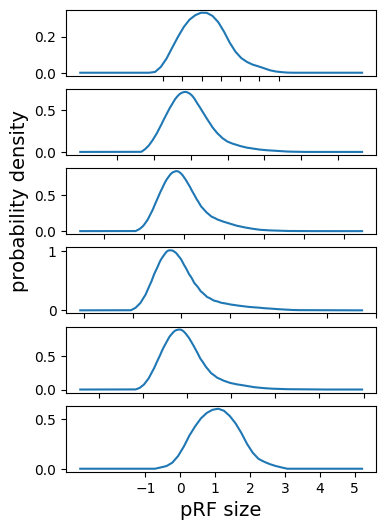

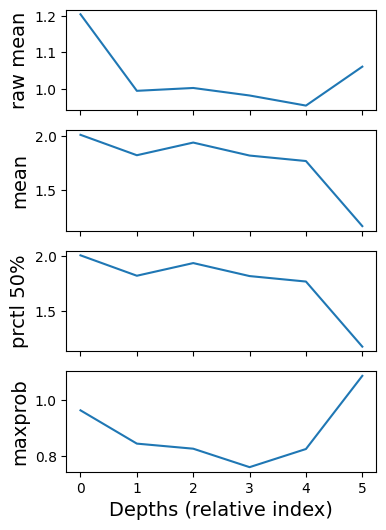

In [87]:
pRFsizes = V3_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

# CI array init
V3_CI_lower = np.zeros([n_depth,])
V3_CI_upper = np.zeros([n_depth,])
V3_SE = np.zeros([n_depth,])
V3_SD = np.zeros([n_depth,])
V3_HDI = np.zeros([n_depth,2])

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    ax[n].set_xticks(np.arange(-1,6))
    if n != len(depth)-1 :
        ax[n].set_xticklabels([])
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
    
    # get 95% HDI (high density interval)
    data = np.array(X)
    data = data[np.isfinite(data)]
    
    density = dens.density
    kde = gaussian_kde(data)
    
    # Evaluate the density function at a range of values
    x = np.linspace(s.min(), s.max(), 1000)
    pdf = kde(x)
    
    # Find the 95% HDI
    q = 0.95
    cdf = np.cumsum(pdf) / np.sum(pdf)
    idx1 = np.argmin(np.abs(cdf - (1 - q) / 2))
    idx2 = np.argmin(np.abs(cdf - (1 + q) / 2))
    V3_HDI[n,:] = [x[idx1], x[idx2]]
    
    # get bootstrapped CI's
    V3_CI_lower[n] = np.percentile(V3_maxprobs[n,:], 2.5)
    V3_CI_upper[n] = np.percentile(V3_maxprobs[n,:], 97.5)
    V3_SE[n] = np.std(V3_maxprobs[n,:], ddof=1) / np.sqrt(n_boot)
    V3_SD[n] = np.std(V3_maxprobs[n,:], ddof=1) 
    
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V3_sigmas=sigmas

Text(0.5, 0, 'Depths (relative index)')

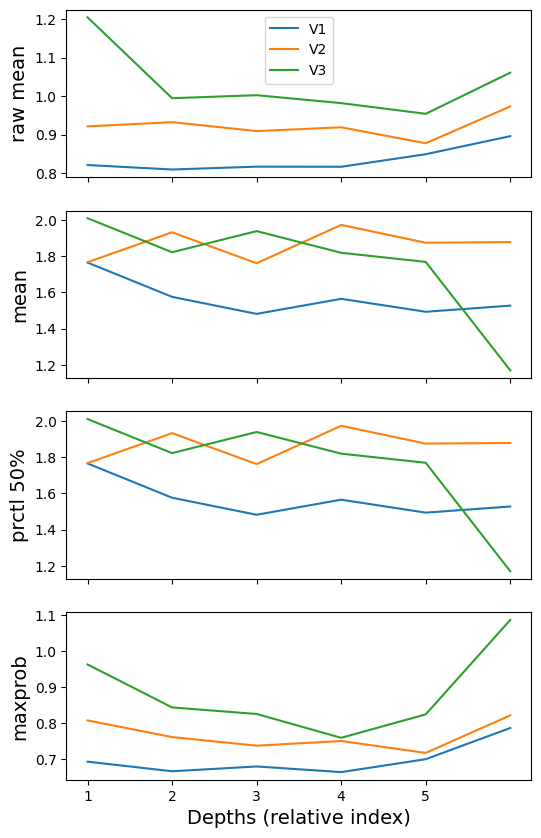

In [88]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(6, 10))
for n in range(4):
    ax[n].plot(V1_sigmas[:,n])
    ax[n].plot(V2_sigmas[:,n])
    ax[n].plot(V3_sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
    else:
        ax[n].set_xticks([0,1,2,3,4])
        ax[n].set_xticklabels([1,2,3,4,5])
    if n == 0 :
        ax[n].legend(['V1','V2','V3'])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)


In [89]:
V3_HDI

array([[-0.06499185,  3.39519252],
       [ 0.26724233,  2.45523942],
       [ 0.32078624,  2.35777683],
       [ 0.33785462,  2.40717415],
       [ 0.33749912,  2.21986294],
       [ 0.22777385,  2.07968333]])

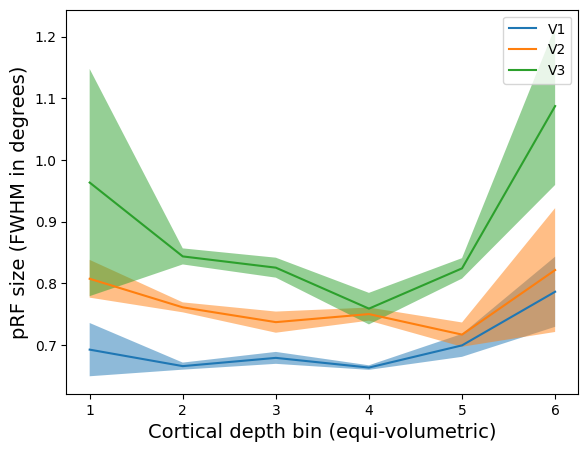

In [142]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

start_depth = 0
n = 3 #only plot max prob
use_cortdist=False
errorbar='SD' #'SE', 'SD', 'CI', 'HDI'
if errorbar=='SE':
    nr_ses = 3 # nr of standard errors of the mean
elif errorbar=='SD':
    nr_sds = 1 # nr of standard deviations of the mean
    
# get list of cortical layers
if start_depth==1:
    x_allROI = np.arange(0,len(depth)-1)
else:
    x_allROI = np.arange(0,len(depth))

if use_cortdist:
    # get cortical distances in mm for each ROI
    x_V1 = np.zeros([n_depth,])
    x_V2 = np.zeros([n_depth,])
    x_V3 = np.zeros([n_depth,])
    for n in range(0,len(depth)):
        x_V1[n] = np.mean(V1_cortdist_list[n])
        x_V2[n] = np.mean(V2_cortdist_list[n])
        x_V3[n] = np.mean(V3_cortdist_list[n])
else:
    x_V1, x_V2, x_V3 = x_allROI, x_allROI, x_allROI

#V1
hndl1,=ax.plot(x_V1,V1_sigmas[start_depth:,3])
if errorbar=='CI':
    ax.fill_between(x_V1, V1_CI_lower[start_depth:,], V1_CI_upper[start_depth:,],alpha=0.5)
elif errorbar=='SE':
    ax.fill_between(x_V1, V1_sigmas[start_depth:,3]-nr_ses*V1_SE[start_depth:,], V1_sigmas[start_depth:,3]+nr_ses*V1_SE[start_depth:,],alpha=0.5)
elif errorbar=='SD':
    ax.fill_between(x_V1, V1_sigmas[start_depth:,3]-nr_sds*V1_SD[start_depth:,], V1_sigmas[start_depth:,3]+nr_sds*V1_SD[start_depth:,],alpha=0.5)
elif errorbar=='HDI':
    ax.fill_between(x_V1, V1_HDI[start_depth:,0], V1_HDI[start_depth:,1],alpha=0.5)

#V2
hndl2,=ax.plot(x_V2,V2_sigmas[start_depth:,3])
if errorbar=='CI':
    ax.fill_between(x_V2, V2_CI_lower[start_depth:,], V2_CI_upper[start_depth:,],alpha=0.5)
elif errorbar=='SE':
    ax.fill_between(x_V2, V2_sigmas[start_depth:,3]-nr_ses*V2_SE[start_depth:,], V2_sigmas[start_depth:,3]+nr_ses*V2_SE[start_depth:,],alpha=0.5)
elif errorbar=='SD':
    ax.fill_between(x_V2, V2_sigmas[start_depth:,3]-nr_sds*V2_SD[start_depth:,], V2_sigmas[start_depth:,3]+nr_sds*V2_SD[start_depth:,],alpha=0.5)
elif errorbar=='HDI':
    ax.fill_between(x_V2, V2_HDI[start_depth:,0], V2_HDI[start_depth:,1],alpha=0.5)

#V3
hndl3,=ax.plot(x_V3,V3_sigmas[start_depth:,3])
if errorbar=='CI':
    ax.fill_between(x_V3, V3_CI_lower[start_depth:,], V3_CI_upper[start_depth:,],alpha=0.5)
elif errorbar=='SE':
    ax.fill_between(x_V3, V3_sigmas[start_depth:,3]-nr_ses*V3_SE[start_depth:,], V3_sigmas[start_depth:,3]+nr_ses*V3_SE[start_depth:,],alpha=0.5)
elif errorbar=='SD':
    ax.fill_between(x_V3, V3_sigmas[start_depth:,3]-nr_sds*V3_SD[start_depth:,], V3_sigmas[start_depth:,3]+nr_sds*V3_SD[start_depth:,],alpha=0.5)
elif errorbar=='HDI':
    ax.fill_between(x_V3, V3_HDI[start_depth:,0], V3_HDI[start_depth:,1],alpha=0.5)

# add xticks and labels
if use_cortdist:
    n_ticks=8
    ax.set_xticks(np.linspace(round(np.min(np.concatenate([x_V1,x_V2,x_V3])),1),
            round(np.max(np.concatenate([x_V1,x_V2,x_V3])),1),n_ticks))
    ax.set_xlabel('Cortical depth [mm]', fontsize=14)
else:
    ax.set_xlabel('Cortical depth bin (equi-volumetric)', fontsize=14)
    if start_depth==1:
        ax.set_xticks(np.arange(0,len(depth)-1))
        ax.set_xticklabels(np.arange(1,len(depth)))
    elif start_depth==0:
        ax.set_xticks(np.arange(0,len(depth)))
        ax.set_xticklabels(np.arange(1,len(depth)+1))

# add ylabel, title, legend
ax.set_ylabel('pRF size (FWHM in degrees)', rotation=90, fontsize=14)
ax.legend([hndl1,hndl2,hndl3],['V1','V2','V3'])
# if prf_model=='prfpy_Iso2DGaussianModel_LinearDeveining':
#     ax.set_title('Iso-2D Gaussian pRF model, linear deveining')
# elif prf_model=='prfpy_Iso2DGaussianModel':
#     ax.set_title('Iso 2D Gaussian pRF model, no deveining')



### Separate plots for each ROI

2.3548200450309493

Text(0, 0.5, 'pRF size (FWHM in degrees)')

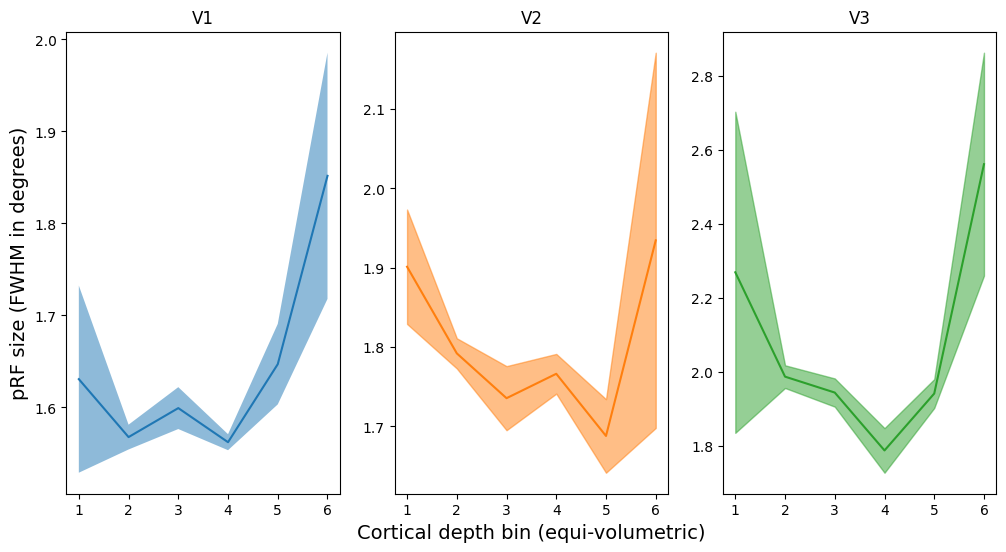

In [140]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12, 6))
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

start_depth = 0
n = 3 #only plot max prob
use_cortdist=False
FWHM=True
errorbar='SD' #'SE', 'SD', 'CI', 'HDI'
if errorbar=='SE':
    nr_ses = 3 # nr of standard errors of the mean
elif errorbar=='SD':
    nr_sds = 1 # nr of standard deviations of the mean
if FWHM:
    scale_factor = np.sqrt(8*np.log(2))
else:
    scale_factor = 1
    
# get list of cortical layers
if start_depth==1:
    x_allROI = np.arange(0,len(depth)-1)
else:
    x_allROI = np.arange(0,len(depth))

if use_cortdist:
    # get cortical distances in mm for each ROI
    x_V1 = np.zeros([n_depth,])
    x_V2 = np.zeros([n_depth,])
    x_V3 = np.zeros([n_depth,])
    for n in range(0,len(depth)):
        x_V1[n] = np.mean(V1_cortdist_list[n])
        x_V2[n] = np.mean(V2_cortdist_list[n])
        x_V3[n] = np.mean(V3_cortdist_list[n])
else:
    x_V1, x_V2, x_V3 = x_allROI, x_allROI, x_allROI

#V1
ax[0].set_title('V1')
ax[0].plot(x_V1,scale_factor*V1_sigmas[start_depth:,3])
if errorbar=='CI':
    ax[0].fill_between(x_V1, scale_factor*V1_CI_lower[start_depth:,], scale_factor*V1_CI_upper[start_depth:,],alpha=0.5)
elif errorbar=='SE':
    ax[0].fill_between(x_V1, scale_factor*(V1_sigmas[start_depth:,3]-nr_ses*V1_SE[start_depth:,]), scale_factor*(V1_sigmas[start_depth:,3]+nr_ses*V1_SE[start_depth:,]),alpha=0.5)
elif errorbar=='SD':
    ax[0].fill_between(x_V1, scale_factor*(V1_sigmas[start_depth:,3]-nr_sds*V1_SD[start_depth:,]), scale_factor*(V1_sigmas[start_depth:,3]+nr_sds*V1_SD[start_depth:,]),alpha=0.5)
elif errorbar=='HDI':
    ax[0].fill_between(x_V1, scale_factor*V1_HDI[start_depth:,0], scale_factor*V1_HDI[start_depth:,1],alpha=0.5)

#V2
ax[1].set_title('V2')
ax[1].plot(x_V2,scale_factor*V2_sigmas[start_depth:,3],color="C{}".format(1))
if errorbar=='CI':
    ax[1].fill_between(x_V2, scale_factor*V2_CI_lower[start_depth:,], scale_factor*V2_CI_upper[start_depth:,],alpha=0.5,color="C{}".format(1))
elif errorbar=='SE':
    ax[1].fill_between(x_V2, scale_factor*(V2_sigmas[start_depth:,3]-nr_ses*V2_SE[start_depth:,]), scale_factor*(V2_sigmas[start_depth:,3]+nr_ses*V2_SE[start_depth:,]),alpha=0.5,color="C{}".format(1))
elif errorbar=='SD':
    ax[1].fill_between(x_V2, scale_factor*(V2_sigmas[start_depth:,3]-nr_sds*V2_SD[start_depth:,]), scale_factor*(V2_sigmas[start_depth:,3]+nr_sds*V2_SD[start_depth:,]),alpha=0.5,color="C{}".format(1))
elif errorbar=='HDI':
    ax[1].fill_between(x_V2, scale_factor*V2_HDI[start_depth:,0], scale_factor*V2_HDI[start_depth:,1],alpha=0.5,color="C{}".format(1))

#V3
ax[2].set_title('V3')
ax[2].plot(x_V3,scale_factor*V3_sigmas[start_depth:,3],color="C{}".format(2))
if errorbar=='CI':
    ax[2].fill_between(x_V3, scale_factor*V3_CI_lower[start_depth:,], scale_factor*V3_CI_upper[start_depth:,],alpha=0.5,color="C{}".format(2))
elif errorbar=='SE':
    ax[2].fill_between(x_V3, scale_factor*(V3_sigmas[start_depth:,3]-nr_ses*V3_SE[start_depth:,]), scale_factor*(V3_sigmas[start_depth:,3]+nr_ses*V3_SE[start_depth:,]),alpha=0.5,color="C{}".format(2))
elif errorbar=='SD':
    ax[2].fill_between(x_V3, scale_factor*(V3_sigmas[start_depth:,3]-nr_sds*V3_SD[start_depth:,]), scale_factor*(V3_sigmas[start_depth:,3]+nr_sds*V3_SD[start_depth:,]),alpha=0.5,color="C{}".format(2))
elif errorbar=='HDI':
    ax[2].fill_between(x_V3, scale_factor*V3_HDI[start_depth:,0], scale_factor*V3_HDI[start_depth:,1],alpha=0.5,color="C{}".format(2))

# add xticks and labels
if use_cortdist:
    n_ticks=8
    for i in range(0,n_rois):
        ax[i].set_xticks(np.linspace(round(np.min(np.concatenate([x_V1,x_V2,x_V3])),1),
                round(np.max(np.concatenate([x_V1,x_V2,x_V3])),1),n_ticks))
        ax[i].set_xlabel('Cortical depth [mm]', fontsize=14)
else:
    for i in range(0,n_rois):
        if start_depth==1:
            ax[i].set_xticks(np.arange(0,len(depth)-1))
            ax[i].set_xticklabels(np.arange(1,len(depth)))
        elif start_depth==0:
            ax[i].set_xticks(np.arange(0,len(depth)))
            ax[i].set_xticklabels(np.arange(1,len(depth)+1))
ax[1].set_xlabel('Cortical depth bin (equi-volumetric)', fontsize=14)

# add ylabel, title, legend
ax[0].set_ylabel('pRF size (FWHM in degrees)', rotation=90, fontsize=14)
# if prf_model=='prfpy_Iso2DGaussianModel_LinearDeveining':
#     ax.set_title('Iso-2D Gaussian pRF model, linear deveining')
# elif prf_model=='prfpy_Iso2DGaussianModel':
#     ax.set_title('Iso 2D Gaussian pRF model, no deveining')


In [141]:
for n in range(0,len(V2_all_sigma_list)):
    print(len(V1_cortdist_list[n]))

121
2083
2796
3106
2097
110


In [92]:
# x_V1 = np.zeros([n_depth,])
# x_V2 = np.zeros([n_depth,])
# x_V3 = np.zeros([n_depth,])
# for n in range(0,len(depth)):
#     x_V1[n] = np.mean(V1_cortdist_list[n])
#     x_V2[n] = np.mean(V2_cortdist_list[n])
#     x_V3[n] = np.mean(V3_cortdist_list[n])

In [93]:
sub_id=0
hem_id=0

In [94]:
# prfpy_dir    = '/home/mayajas/scratch/project-00-7t-pipeline-dev/output/'+prf_model+'/'+subject_list[sub_id]
# proj_dir     = '/home/mayajas/scratch/project-00-7t-pipeline-dev/'
# data_dir     = opj(proj_dir,'output','func','sliceTimeCorr',
#                 '_subject_id_'+subject_list[sub_id])
# ROI_dir      = opj(prfpy_dir,'ROIs')
# if layer_space == 'func':
#     lay_dir      = opj(prfpy_dir,'layerification_func')
# else:
#     lay_dir      = opj(prfpy_dir,'layerification')
# lay_dir_func     = opj(prfpy_dir,'layerification_func')

# # image files
# meanFunc_fn  = opj(prfpy_dir,'meanFunc.nii')
# UNI_func_fn  = opj(prfpy_dir,'UNI_funcSpace.nii')

# GM_fn        = opj(prfpy_dir,
#                 hem_list[hem_id]+'_GM_funcSpace.nii')
# occ_fn       = opj(prfpy_dir,
#                 'funcSpaceOccipitalMask.nii')
# bar1_fn      = opj(data_dir,'_sess_id_task-bar_run-01_sess_nr_0_sess_nvol_124','atask-bar_run-01_roi_warp4D.nii')
# bar2_fn      = opj(data_dir,'_sess_id_task-bar_run-02_sess_nr_1_sess_nvol_124','atask-bar_run-02_roi_warp4D.nii')


# # prfpy output files
# grid_fit_fn      = opj(prfpy_dir,hem_list[hem_id]+'_grid_fit.pckl')
# iterative_fit_fn = opj(prfpy_dir,hem_list[hem_id]+'_iterative_fit.pckl')
# pRF_param_fn     = opj(prfpy_dir,hem_list[hem_id]+'_pRF_params.pckl')
# equivol_param_fn = opj(prfpy_dir,hem_list[hem_id]+'_pRF_params_equivol.pckl')
# equidist_param_fn = opj(prfpy_dir,hem_list[hem_id]+'_pRF_params_equidist.pckl')


# # manual ROI delineations
# V1_fn        = opj(ROI_dir,'func_'+hem_list[hem_id]+'_V1.nii')
# V2_fn        = opj(ROI_dir,'func_'+hem_list[hem_id]+'_V2.nii')
# V3_fn        = opj(ROI_dir,'func_'+hem_list[hem_id]+'_V3.nii')
# ecc2_fn      = opj(ROI_dir,'func_'+hem_list[hem_id]+'_ecc2.nii')

# # layers
# lay_equidist_fn = opj(lay_dir,'func_ribbon_rim_layers_equidist.nii')
# lay_equivol_fn = opj(lay_dir,'func_ribbon_rim_layers_equivol.nii')

# # cortical distances (mm)
# cortdist_fn = opj(lay_dir_func,'cortical_distances.nii')

In [95]:
# ###########################################################################################
# ## Load image files
# occ = nib.load(occ_fn)
# GM = nib.load(GM_fn)
# meanFunc = nib.load(meanFunc_fn)
# UNI = nib.load(UNI_func_fn)

# V1=nib.load(V1_fn)
# V2=nib.load(V2_fn)
# V3=nib.load(V3_fn)

# ecc2=nib.load(ecc2_fn)

# lay_equidist=nib.load(lay_equidist_fn)
# lay_equivol=nib.load(lay_equivol_fn)
# cort_distances=nib.load(cortdist_fn)


# # define mask (GM+occipital) and process bar data and masker
# mask = image.math_img("np.logical_and(img1, img2)", img1=occ, img2=GM)
# masker = NiftiMasker(mask_img=mask)

# # mask input files
# masked_meanFunc = masker.fit_transform(meanFunc)
# masked_meanFunc = np.squeeze(masked_meanFunc)

# masked_V1 = masker.fit_transform(V1)
# masked_V1 = np.squeeze(masked_V1)

# masked_V2 = masker.fit_transform(V2)
# masked_V2 = np.squeeze(masked_V2)

# masked_V3 = masker.fit_transform(V3)
# masked_V3 = np.squeeze(masked_V3)

# masked_ecc2 = masker.fit_transform(ecc2)
# masked_ecc2 = np.squeeze(masked_ecc2)

# masked_lay_equidist = masker.fit_transform(lay_equidist)
# masked_lay_equidist = np.squeeze(masked_lay_equidist)

# masked_lay_equivol = masker.fit_transform(lay_equivol)
# masked_lay_equivol = np.squeeze(masked_lay_equivol)

# masked_cort_distances = masker.fit_transform(cort_distances)
# masked_cort_distances = np.squeeze(masked_cort_distances)

In [96]:
# ###########################################################################################
# ## Load pRF results
# f = open(pRF_param_fn,'rb')
# x, y, sigma, total_rsq, polar, ecc = pickle.load(f)
# f.close()

In [97]:
# layers
# for layer in range(int(min(np.unique(masked_lay_equivol))),int(max(np.unique(masked_lay_equivol)))):
#     print(layer)

In [98]:
# np.unique(masked_lay_equivol)

In [99]:
# layers     = np.arange(1,n_layers+1)
# layers